# <a id='toc1_'></a>[Project: Twitter API and 'We Rate Dogs'](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Project: Twitter API and 'We Rate Dogs'](#toc1_)    
  - [Starting Code](#toc1_1_)    
  - [Data Gathering](#toc1_2_)    
  - [Assessing Data](#toc1_3_)    
    - [Code for Assessing api_df](#toc1_3_1_)    
    - [Code for Assessing image_df](#toc1_3_2_)    
    - [Code for Assessing twitter_df](#toc1_3_3_)    
    - [Quality issues](#toc1_3_4_)    
    - [Tidiness issues](#toc1_3_5_)    
  - [Cleaning Data](#toc1_4_)    
    - [Issue #1:](#toc1_4_1_)   
    - ... 
    - [Issue #10:](#toc1_4_10_)   
  - [Storing Data](#toc1_5_)    
  - [Analyzing and Visualizing Data](#toc1_6_)    
    - [Insights:](#toc1_6_1_)    
    - [Feature Engineering](#toc1_6_2_)    
    - [Normalize Probabilities:](#toc1_6_3_)    
    - [Adding time information](#toc1_6_4_)    
    - [Setting up Popularity Rating and dummy variables for multiple linear regression model](#toc1_6_5_)    
  - [Comedic Linear Regression Model for Engagement:](#toc1_7_)    
  - [Setting up Dog Breed Columns](#toc1_8_)    
    - [Setting up for Logistic Regression analysis on Dog Breeds and Monikers](#toc1_8_1_)    
  - [Predict the Popularity Ratings from Breed](#toc1_9_)    
  - [Multiple Linear Regression Model for Engagement:](#toc1_10_)    
  - [Model Questions](#toc1_11_)    
    - [Relationship Questions](#toc1_11_1_)    
    - [Visualization](#toc1_11_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Starting Code](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import requests
# import os
import tweepy
import json
# from time import sleep
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
%matplotlib inline

import re
import datetime as dt
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)

pd.set_option('display.max_columns', 50)


## <a id='toc1_2_'></a>[Data Gathering](#toc0_)
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# read in csv file on disk
twitter_df = pd.read_csv('Data/twitter-archive-enhanced (1).csv')



2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv') 

with open('Data/image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

image_df = pd.read_csv('Data/image-predictions.tsv', sep='\t')



3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
keys = pd.read_json('Data/credentials.json', typ='series')

consumer_key = keys.consumer_key
consumer_secret = keys.consumer_secret
access_token = keys.access_token
access_secret = keys.access_secret

bearer_token = keys.bearer_token


# client = tweepy.Client(bearer_token = bearer_token, wait_on_rate_limit = True)

client = tweepy.Client(
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    access_token=access_token,
    access_token_secret=access_secret
    )


In [5]:
# Authenticate to Twitter
auth = tweepy.OAuth1UserHandler(                                # type 1 for API or v1.1
   consumer_key, consumer_secret, access_token, access_secret
)

# Create API object
api = tweepy.API(auth, wait_on_rate_limit=True)
                #  wait_on_rate_limit_notify=True


In [6]:
# count = 0

# # # Print the text of each tweet
# with open('tweets_json.txt', 'w') as outfile:
#    for tweet_id in tqdm(twitter_df.tweet_id):
#       try:
#          tweet_status_dict = api.get_status(tweet_id, tweet_mode='extended')._json
#         #  data = {
#         #        'id': tweet_status.id,
#         #        'created_at': tweet_status.created_at,
#         #        'retweet_count': tweet_status.retweet_count,
#         #        'favorite_count' : tweet_status,
#         #        'text_length': len(tweet_status.full_text),
#         #        'text': tweet_status.full_text
#         #        }
#          json_line = json.dumps(tweet_status_dict)
#          outfile.write(json_line)
#          outfile.write('\n')
#          print(tweet_id)
#       except:
#          print(f"Unable to get {tweet_id}")
#          count += 1
#          print(count)

# api.get_status(twitter_df.tweet_id[0], tweet_mode='extended')._json


In [7]:
list_tweets = []
with open('Data/tweets_json.txt', 'r') as json_file:
    for i in tqdm(json_file):
        json_string = json.loads(i)
        tweet = {
        'tweet_id': json_string['id'],
        'created_at': pd.to_datetime(json_string['created_at']),
        'retweet_count': int(json_string['retweet_count']),
        'favorite_count' : int(json_string['favorite_count']),
        # 'favourites_count': json_string['user']['favourites_count'],
        # 'followers_count': json_string['user']['followers_count'],
        # 'retweeted': json_string['retweeted'],
        # 'text_length': len(json_string['full_text']),
        # 'text': json_string['full_text']
        # 'q_count': json_string['user']['quote_count'],
        # 'r_count': json_string['user']['reply_count'],
        }

        list_tweets.append(tweet)
        

api_df = pd.DataFrame(list_tweets)


0it [00:00, ?it/s]

In [8]:
api_df.head()

,tweet_id,created_at,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,6818,32611
1,892177421306343426,2017-08-01 00:17:27+00:00,5130,28199
2,891815181378084864,2017-07-31 00:18:03+00:00,3390,21167
3,891689557279858688,2017-07-30 15:58:51+00:00,7023,35544
4,891327558926688256,2017-07-29 16:00:24+00:00,7546,33945


## <a id='toc1_3_'></a>[Assessing Data](#toc0_)



In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

> The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. You'll need to assess and clean these columns if you want to use them for analysis and visualization.
>
> 

### <a id='toc1_3_1_'></a>[Code for Assessing api_df](#toc0_)

In [9]:
# three data sets: api_df, image_df, twitter_df
api_df.head()


,tweet_id,created_at,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,6818,32611
1,892177421306343426,2017-08-01 00:17:27+00:00,5130,28199
2,891815181378084864,2017-07-31 00:18:03+00:00,3390,21167
3,891689557279858688,2017-07-30 15:58:51+00:00,7023,35544
4,891327558926688256,2017-07-29 16:00:24+00:00,7546,33945


In [10]:
api_df.info()
api_df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2326 non-null   int64              
 1   created_at      2326 non-null   datetime64[ns, UTC]
 2   retweet_count   2326 non-null   int64              
 3   favorite_count  2326 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 72.8 KB


tweet_id          2326
created_at        2326
retweet_count     1648
favorite_count    1972
dtype: int64

### <a id='toc1_3_2_'></a>[Code for Assessing image_df](#toc0_)

In [11]:
image_df.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
image_df['p1'].value_counts()

p1
golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: count, Length: 378, dtype: int64

In [13]:
image_df.info()
image_df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

### <a id='toc1_3_3_'></a>[Code for Assessing twitter_df](#toc0_)

In [14]:
twitter_df.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


In [15]:
twitter_df.info()
twitter_df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           956
doggo                            1
floofer                          1
pupper                           1
puppo                            1
dtype: int64

In [16]:
def regex_checker(regex='[Pp]uppo?\W', old_name='puppo', dataframe=twitter_df, update=False):
    s1 = set(dataframe[dataframe.text.str.contains(regex)].tweet_id) # s?\W
    s2 = set(dataframe[dataframe[f'{old_name}'] == old_name].tweet_id)
    
    print(len(s1), len(s2), len(s1.symmetric_difference(s2)))
    for i in dataframe[dataframe.tweet_id.isin(s1.symmetric_difference(s2))].text[:10]:
        print(i)

    if update == True:
        dataframe[old_name] = dataframe.text.str.contains(regex)
        print(f'The updated column of {old_name} now has \n', dataframe[old_name].value_counts())


In [17]:

regex_checker()


30 30 0


In [18]:
regex_checker('[Pp]uppers?\W', 'pupper')


276 257 27
RT @alexmartindawg: THE DRINK IS DR. PUPPER 10/10 good pun @matt___nelson @GoodDogsGame https://t.co/act3duiqbL
This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd
SWIM AWAY PUPPER SWIM AWAY 13/10 #BarkWeek  https://t.co/QGGhZoTcwy
This is Arlen and Thumpelina. They are best pals. Cuddly af. 11/10 for both puppers https://t.co/VJgbgIzIHx
Everybody stop what you're doing and watch these puppers enjoy summer. Both 13/10 https://t.co/wvjqSCN6iC
Here are two lil cuddly puppers. Both 12/10 would snug like so much https://t.co/zO4eb7C4tG
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
WeRateDogs stickers are here and they're 12/10! Use code "puppers" at checkout 🐶🐾

Shop now: https://t.co/k5xsufRKYm https://t.co/ShXk46V13r
Here is a whole fl

In [19]:
regex_checker('[Ff]loofs?e?r?s?\W', 'floofer')


31 10 21
This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp
This is Rey. He's a Benebop Cumberfloof. 12/10 dangerously pettable https://t.co/503CgWbhxQ
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
This is Yogi. He's 98% floof. Snuggable af. 12/10 https://t.co/opoXKxmfFm
Here's a perturbed super floof. 12/10 would snug so damn well https://t.co/VG095mi09Q
We only rate dogs. Pls stop sending in non-canines like this Urban Floof Giraffe. I can't handle this. 11/10 https://t.co/zHIqpM5Gni
RT @dog_rates: This is Arnie. He's a Nova Scotian Fridge Floof. Rare af. 12/10 https://t.co/lprdOylVpS
This is Heinrich (pronounced "Pat"). He's a Botswanian Vanderfloof. Snazzy af bandana. 12/10 downright puptacular https://t.co/G56ikYAqFg
We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 1

In [20]:
regex_checker('[Dd]oggos?\W', 'doggo')


106 97 11
I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu
Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL
RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…
DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE 10/10 https://t.co/ffIH2WxwF0
RT @dog_rates: Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!

https://…
Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!

https://t.co/r4W111FzAq https://t.co/fQpYuMKG3p
You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV
Here we are witnessing an isolated squad of bouncing doggos. Unbelievably rare for th

In [21]:
twitter_df.name.value_counts().head(10)

name
a          55
Charlie    12
Oliver     11
Cooper     11
Lucy       11
Lola       10
Tucker     10
Penny      10
Bo          9
Winston     9
Name: count, dtype: int64

In [22]:
mask = twitter_df['name'].str.contains('^[^A-Z]', na=False)
twitter_df.name[mask].value_counts().head(10)


name
a           55
the          8
an           7
very         5
just         4
quite        4
one          4
getting      2
actually     2
mad          2
Name: count, dtype: int64

In [23]:
twitter_df.rating_numerator.value_counts().head(10)

rating_numerator
12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
Name: count, dtype: int64

In [24]:
twitter_df.rating_denominator.value_counts().head(10)



rating_denominator
10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
Name: count, dtype: int64

In [25]:
for i in twitter_df.query('rating_denominator != 10 or rating_numerator not in [7, 8, 9, 10, 11, 12, 13, 14, 15]')['text'][:10]:
    print(i)

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1
@markhoppus 182/10
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
@docmisterio a

In [26]:
for i, j in zip(twitter_df.query('rating_numerator > 15').text[:10], twitter_df.query('rating_numerator > 15').rating_numerator[:10]):
    print(i, j)

@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s 17
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research 420
@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10 666
@markhoppus 182/10 182
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 960
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… 75
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 84
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 24
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 75


In [27]:
twitter_df.apply(lambda x: str(x.rating_numerator) + '/'+ str(x.rating_denominator), axis = 1).value_counts().head(10)

12/10    558
11/10    463
10/10    461
13/10    351
9/10     156
8/10     102
7/10      54
14/10     54
5/10      37
6/10      32
Name: count, dtype: int64

In [28]:
for i in twitter_df[twitter_df.in_reply_to_status_id.notna()].text[:10]:
    print(i)

@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
@RealKentMurphy 14/10 confirmed
@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs
@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10
Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen
@Marc_IRL pixelated af 12/10
THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA
@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your 

In [29]:
for i in twitter_df[twitter_df.retweeted_status_id.notna()].text[:10]:
    print(i)

RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX
RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo
RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5
RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…
RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below

https:/…
RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…
RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G
RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly ht

### <a id='toc1_3_4_'></a>[Quality issues](#toc0_)

1. api_df has 30 missing tweet entries compared with the twitter_df. - Completeness

2. image_df has 281 less data entries as compared with twitter_df and potentially has multiple images for some entries. - Completeness

3. All of the reply tweets do not contain dog pictures or are just dialogue with that were flagged as having 'ratings' in them due to random numbers strings. Same with all the retweets. - Completeness

4. Doggo, floofer, pupper, and puppo are strings and only have 2 unique values per column. - Validity
   
5. The Doggo, floofer, pupper, and puppo columns do not contain all the mentions of those names in the text. - Accuracy

6. Source only 4 has unique values and is string datatype. 
   -  Could be a categorical variable with just 4 categories. - Validity 

7. Timestamp column in twitter_df is string. - Validity 
   -  Change data type to datetime or use retrieved datetimes from api_df. 

8. Remove Https address from text. - Consistency
   -  This is included in another column and is not needed in the text column.

9.  Some strings in the Names category are None and some are not names. - Validity
    -  Replace None and non-names with NaN.

10. Ratings are a finite set of ratios. Also Ratings are sometimes erratic and hard to interpret with high amounts of linguistic context. - Validity and Accuracy
    1. All ratings with numerators above 16 or with a denominator above 19 are actually pictures of multiple dogs. This will probably show up as more 'confusing' or 'lower dog likelihoods' in the picture prediction dataframe. 
    2. All ratings with numerators below 10 either involve dogs doing 'bad' things (drinking alcohol, pushing a dog into water), or they are not dogs (cats, ducks, snow, etc). This will probably show up 'False' or 'Not Predicted to be a dog' in the picture prediction dataframe. 
    3. Denominators below 20 that are not 10 are always errors of regex extraction.
    4. Ratings Would be better represented as categories once reduced down to important rankings. Expected categories might be for all the most common ratios (7/10, 8/10, 9/10, 10/10, 11/10, 12/10, 13/10, 14/10, 15/10). Might also make one a category for ratings with a numerator above 15 and one category for below numerator of 7, or I might just label these as aberrants.


### <a id='toc1_3_5_'></a>[Tidiness issues](#toc0_)

1.   The three dataframes are separate. - Tables 
     -    Combine them into one master dataframe on tweet_id. 
   
2.   Numerator and Denominator are in two separate columns although they are one piece of information. - Columns  
     -    Combine these two columns into a new singular column. 


- Main Questions:
    - What type of dogs get the most retweets and favorites.
    - What type of ratings gets the most retweets and favorites.
    - What type of monikers get the most retweets and favorites.
- Subquestions:
    - Most popular time of day to tweet.
    - Relationship between ratings and dog breeds predictions.
    - Relationship between ratings and monikers.
    - Most Popular Dog Name
    - Histogram of Dog Ratings
    - Relationship between dog breeds and moniker


## <a id='toc1_4_'></a>[Cleaning Data](#toc0_)



In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [30]:
# Make copies of original pieces of data
clean_twitter_df = twitter_df.copy()
clean_api_df = api_df.copy()
clean_image_df = image_df.copy()

### <a id='toc1_4_1_'></a>[Issue #1:](#toc0_)

#### <a id='toc1_4_1_1_'></a>[Define:](#toc0_)



The first issues I wanted to address were all the Completeness issues. However, they would all be much easier to accomplish if I merged the 3 dfs together. This would accomplish three of my issues in one swoop. Here is my breakdown of each issue.

**Quality**:
1. api_df has 30 missing tweet entries compared with the twitter_df. - Completeness  
   - Check to see if there is some commonality with the missing tweets. Otherwise, consider deleting incomplete data from twitter_df. 

2. image_df has 281 less data entries as compared with twitter_df and potentially has multiple images for some entries. - Completeness
   - Check to see if there is some commonality with the missing tweets. Otherwise, consider deleting incomplete data from twitter_df. 

**Tidiness**:   

2. Combine the three dataframes into one master dataframe on tweet_id. - Tables   
   - Use pd.merge to merge all three dfs on tweet_id



#### <a id='toc1_4_1_2_'></a>[Code](#toc0_)

In [31]:
master_df = pd.merge(clean_twitter_df, clean_api_df,\
                                how='outer', on='tweet_id', sort=True, copy=True)

master_df = pd.merge(master_df, clean_image_df,\
                                how='outer', on='tweet_id', sort=True, copy=True)

print(master_df.columns)

master_df.info()
master_df.head()


Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'created_at', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,NaN,NaN,NaN,NaN,2015-11-15 22:32:08+00:00,412.0,2211.0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN,NaN,NaN,NaN,2015-11-15 23:05:30+00:00,39.0,109.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN,NaN,NaN,NaN,2015-11-15 23:21:54+00:00,35.0,96.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN,NaN,NaN,NaN,2015-11-16 00:04:52+00:00,111.0,240.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,NaN,NaN,NaN,2015-11-16 00:24:50+00:00,36.0,85.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [32]:
# assess tweets that were not able to be retrieved by api

master_df[master_df.retweet_count.isna()].describe()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,3.000000e+01,0.0,0.0,2.200000e+01,2.200000e+01,30.000000,30.000000,0.0,0.0,19.000000,19.000000,19.000000,19.000000
mean,8.231730e+17,NaN,NaN,8.055049e+17,3.213018e+09,12.233333,10.033333,NaN,NaN,1.157895,0.612120,0.115264,0.051903
std,5.003710e+16,NaN,NaN,6.242902e+16,1.671271e+09,1.478194,0.182574,NaN,NaN,0.374634,0.270305,0.092233,0.039156
min,6.800555e+17,NaN,NaN,6.800555e+17,6.669901e+07,9.000000,10.000000,NaN,NaN,1.000000,0.153718,0.001834,0.000667
25%,7.761032e+17,NaN,NaN,7.571974e+17,2.348793e+09,12.000000,10.000000,NaN,NaN,1.000000,0.390293,0.053846,0.026886
50%,8.401292e+17,NaN,NaN,8.182406e+17,4.196984e+09,13.000000,10.000000,NaN,NaN,1.000000,0.660085,0.109168,0.047523
75%,8.604782e+17,NaN,NaN,8.584803e+17,4.196984e+09,13.000000,10.000000,NaN,NaN,1.000000,0.783372,0.154253,0.068427
max,8.882025e+17,NaN,NaN,8.874740e+17,4.196984e+09,14.000000,11.000000,NaN,NaN,2.000000,0.995466,0.334947,0.149470


In [33]:
# most of these tweets are retweets, can drop
master_df = master_df.dropna(subset='retweet_count')

In [34]:
# assess tweets that did not have an image associated with them
master_df[master_df.p1_conf.isna()].head() 


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
57,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,NaN,2015-11-18 20:02:51+00:00,12.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Never forget this vine. You will not stop watc...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,NaN,NaN,NaN,NaN,2015-11-23 00:30:28+00:00,908.0,1431.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\r\n@wane15,NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN,2015-11-24 01:42:25+00:00,18.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,NaN,NaN,NaN,NaN,NaN,2015-11-26 01:11:28+00:00,73.0,433.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,NaN,NaN,NaN,NaN,NaN,2015-12-01 04:44:10+00:00,182.0,788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
master_df[master_df.p1_conf.isna()].describe()
# there are 281 tweets missing pictures, with 100 of those tweets being retweets, 
# and 55 of those tweets being replies. We only want tweets with pictures so others will be dropped.

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2.700000e+02,5.500000e+01,5.500000e+01,8.900000e+01,8.900000e+01,270.000000,270.000000,270.000000,270.000000,0.0,0.0,0.0,0.0
mean,7.724546e+17,7.654538e+17,2.856460e+16,7.738235e+17,1.640463e+16,19.785185,10.040741,3198.307407,3941.103704,NaN,NaN,NaN,NaN
std,6.531322e+16,7.778058e+16,1.487778e+17,6.379616e+16,1.088411e+17,74.940014,0.984172,4361.332419,7428.045709,NaN,NaN,NaN,NaN
min,6.670705e+17,6.658147e+17,1.185634e+07,6.661041e+17,1.960740e+07,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,7.070858e+17,6.852539e+17,6.249032e+07,7.186315e+17,4.196984e+09,11.000000,10.000000,399.000000,0.000000,NaN,NaN,NaN,NaN
50%,7.807001e+17,7.667118e+17,3.105441e+09,7.815247e+17,4.196984e+09,12.000000,10.000000,1603.000000,1429.000000,NaN,NaN,NaN,NaN
75%,8.298303e+17,8.381155e+17,4.196984e+09,8.250266e+17,4.196984e+09,13.000000,10.000000,4542.250000,4281.500000,NaN,NaN,NaN,NaN
max,8.862670e+17,8.862664e+17,8.405479e+17,8.860537e+17,7.475543e+17,960.000000,20.000000,25945.000000,61236.000000,NaN,NaN,NaN,NaN


In [36]:
master_df = master_df.dropna(subset='img_num')

#### <a id='toc1_4_1_3_'></a>[Test](#toc0_)

In [37]:
master_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 2056 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2056 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2056 non-null   object             
 4   source                      2056 non-null   object             
 5   text                        2056 non-null   object             
 6   retweeted_status_id         70 non-null     float64            
 7   retweeted_status_user_id    70 non-null     float64            
 8   retweeted_status_timestamp  70 non-null     object             
 9   expanded_urls               2056 non-null   object             
 10  rating_numerator            2056 non-null   int64              
 

### <a id='toc1_4_2_'></a>[Issue #2:](#toc0_)

#### <a id='toc1_4_2_1_'></a>[Define](#toc0_)



**Quality**:


3. All of the reply tweets do not contain dog pictures or are just dialogue with that were flagged as having 'ratings' in them due to random numbers strings. Same with all the retweets. - Completeness.   
      - Remove these tweets from the master_dataframe.  



#### <a id='toc1_4_2_2_'></a>[Code](#toc0_)

In [38]:
master_df.in_reply_to_status_id.count(), master_df.retweeted_status_user_id.count()

(23, 70)

In [39]:
master_df[master_df.in_reply_to_status_id.isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,NaN,NaN,NaN,NaN,2015-11-15 22:32:08+00:00,412.0,2211.0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN,NaN,NaN,NaN,2015-11-15 23:05:30+00:00,39.0,109.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN,NaN,NaN,NaN,2015-11-15 23:21:54+00:00,35.0,96.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN,NaN,NaN,NaN,2015-11-16 00:04:52+00:00,111.0,240.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,NaN,NaN,NaN,2015-11-16 00:24:50+00:00,36.0,85.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,2017-07-29 16:00:24+00:00,7546.0,33945.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2352,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,2017-07-30 15:58:51+00:00,7023.0,35544.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2353,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,2017-07-31 00:18:03+00:00,3390.0,21167.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2354,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on

In [40]:
master_df = master_df[master_df.in_reply_to_status_id.isna()]

In [41]:
master_df = master_df[master_df.retweeted_status_user_id.isna()]


In [42]:
master_df = master_df.dropna(axis=1, how='all')

#### <a id='toc1_4_2_3_'></a>[Test](#toc0_)

In [43]:
# Drop columns with all values as NaN
master_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1963 entries, 0 to 2355
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1963 non-null   int64              
 1   timestamp           1963 non-null   object             
 2   source              1963 non-null   object             
 3   text                1963 non-null   object             
 4   expanded_urls       1963 non-null   object             
 5   rating_numerator    1963 non-null   int64              
 6   rating_denominator  1963 non-null   int64              
 7   name                1440 non-null   object             
 8   doggo               72 non-null     object             
 9   floofer             8 non-null      object             
 10  pupper              209 non-null    object             
 11  puppo               23 non-null     object             
 12  created_at          1963 non-null   dat

### <a id='toc1_4_3_'></a>[Issue #3:](#toc0_)

#### <a id='toc1_4_3_1_'></a>[Define](#toc0_)


**Tidiness**: 
1.   Numerator and Denominator are in two separate columns although they are one piece of information. - Columns
      -    Combine these two columns into a new singular column.   



#### <a id='toc1_4_3_2_'></a>[Code](#toc0_)

In [44]:
master_df['ratings'] = master_df.rating_numerator.astype('str').str.extract('(\d*)') + '/' + master_df.rating_denominator.astype('str').str.extract('(\d*)')


#### <a id='toc1_4_3_3_'></a>[Test](#toc0_)

In [45]:
master_df['ratings'].value_counts()

ratings
12/10      444
10/10      415
11/10      392
13/10      249
9/10       149
8/10        95
7/10        51
5/10        33
14/10       33
6/10        32
3/10        19
4/10        15
2/10         9
1/10         4
99/90        1
84/70        1
24/7         1
75/10        1
27/10        1
165/150      1
1776/10      1
9/11         1
204/170      1
4/20         1
50/50        1
7/11         1
80/80        1
45/50        1
60/50        1
44/40        1
121/110      1
26/10        1
144/120      1
88/80        1
420/10       1
1/2          1
0/10         1
Name: count, dtype: int64

### <a id='toc1_4_4_'></a>[Issue #4:](#toc0_)

#### <a id='toc1_4_4_1_'></a>[Define](#toc0_)


Fixing the Doggo, Floofer, etc columns required only one piece of code for both problems. So I combined them.

**Quality**:
4. Doggo, floofer, pupper, and puppo are strings and only have 2 unique values per column. 
   1. Should be boolean values instead of strings.  

5. The Doggo, floofer, pupper, and puppo columns do not contain all the mentions of those names in the text. 
   1. Construct regex commands that properly extract all the mentions into boolean values. 



#### <a id='toc1_4_4_2_'></a>[Code](#toc0_)

In [46]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1963 entries, 0 to 2355
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1963 non-null   int64              
 1   timestamp           1963 non-null   object             
 2   source              1963 non-null   object             
 3   text                1963 non-null   object             
 4   expanded_urls       1963 non-null   object             
 5   rating_numerator    1963 non-null   int64              
 6   rating_denominator  1963 non-null   int64              
 7   name                1440 non-null   object             
 8   doggo               72 non-null     object             
 9   floofer             8 non-null      object             
 10  pupper              209 non-null    object             
 11  puppo               23 non-null     object             
 12  created_at          1963 non-null   dat

In [47]:
# def regex_checker(regex='[Pp]uppo?\W', old_name='puppo', dataframe=twitter_df, update=False):

def regex_checker(regex='[Pp]uppo?\W', old_name='puppo', dataframe=twitter_df, update=False):
    # Check if column exists
    if old_name not in dataframe.columns:
        print(f"Column '{old_name}' not found in dataframe!")
        return
    
    s1 = set(dataframe[dataframe.text.str.contains(regex)].tweet_id) # s?\W
    s2 = set(dataframe[dataframe[f'{old_name}'] == old_name].tweet_id)
    
    print(len(s1), len(s2), len(s1.symmetric_difference(s2)))
    for i in dataframe[dataframe.tweet_id.isin(s1.symmetric_difference(s2))].text[:10]:
        print(i)

    if update == True:
        dataframe[old_name] = dataframe.text.str.contains(regex)
        print(f'The updated column of {old_name} now has \n', dataframe[old_name].value_counts())
    
    print(len(s1), len(s2), len(s1.symmetric_difference(s2)))
    for i in dataframe[dataframe.tweet_id.isin(s1.symmetric_difference(s2))].text[:10]:
        print(i)


In [48]:
# def regex_checker(regex='[Pp]uppo?\W', old_name='puppo', dataframe=twitter_df, update=False):

regex_checker(regex='[Pp]uppo?\W', old_name='puppo', dataframe=master_df, update=True)

regex_checker('[Pp]uppers?\W', 'pupper', dataframe=master_df, update=True)

regex_checker('[Ff]loofs?e?r?s?\W', 'floofer', dataframe=master_df, update=True)

regex_checker('[Dd]oggos?\W', 'doggo', dataframe=master_df, update=True)


23 23 0
The updated column of puppo now has 
 puppo
False    1940
True       23
Name: count, dtype: int64
23 23 0
229 209 22
This is Zoey. Her dreams of becoming a hippo ballerina don't look promising. 9/10 it'll be ok puppers https://t.co/kR1fqy4NKK
Herd of wild dogs here. Not sure what they're trying to do. No real goals in life. 3/10 find your purpose puppers https://t.co/t5ih0VrK02
This is Rodman. He's getting destroyed by the surfs. Valiant effort though. 10/10 better than most puppers probably https://t.co/S8wCLemrNb
Happy Friday. Here's some golden puppers. 12/10 for all https://t.co/wNkqAED6lG
Here's a handful of sleepy puppers. All look unaware of their surroundings. Lousy guard dogs. Still cute tho 11/10s https://t.co/lyXX3v5j4s
Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
Hope your Monday isn't too awful. Here's two baseball puppers. 11/10 for each https://t.co/dB0H9hdZai
Here we have uncovered an entire battalio

#### <a id='toc1_4_4_3_'></a>[Test](#toc0_)

In [49]:
master_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1963 entries, 0 to 2355
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1963 non-null   int64              
 1   timestamp           1963 non-null   object             
 2   source              1963 non-null   object             
 3   text                1963 non-null   object             
 4   expanded_urls       1963 non-null   object             
 5   rating_numerator    1963 non-null   int64              
 6   rating_denominator  1963 non-null   int64              
 7   name                1440 non-null   object             
 8   doggo               1963 non-null   bool               
 9   floofer             1963 non-null   bool               
 10  pupper              1963 non-null   bool               
 11  puppo               1963 non-null   bool               
 12  created_at          1963 non-null   dat

In [50]:
master_df[['doggo', 'floofer', 'pupper', 'puppo']].sum()

doggo       78
floofer     28
pupper     229
puppo       23
dtype: int64

### <a id='toc1_4_5_'></a>[Issue #5:](#toc0_)

#### <a id='toc1_4_5_1_'></a>[Define](#toc0_)


**Quality**:  
6. Source only 4 has unique values and is string datatype. 
   - Could be a categorical variable with just 4 categories. - Validity 




#### <a id='toc1_4_5_2_'></a>[Code](#toc0_)

In [51]:
master_df.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [52]:
master_df['source'] = master_df.source.replace({'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone', \
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Web Client', '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'})

#### <a id='toc1_4_5_3_'></a>[Test](#toc0_)

In [53]:
master_df.source.unique()

array(['iPhone', 'Web Client', 'TweetDeck'], dtype=object)

### <a id='toc1_4_6_'></a>[Issue #6:](#toc0_)

#### <a id='toc1_4_6_1_'></a>[Define](#toc0_)


**Quality**:

7. Timestamp column in twitter_df is string. - Validity 
   - Change data type to datetime or use retrieved datetimes from api_df. 



#### <a id='toc1_4_6_2_'></a>[Code](#toc0_)

In [54]:
master_df['timestamp'] = master_df.created_at

In [55]:
master_df = master_df.drop('created_at', axis=1)

#### <a id='toc1_4_6_3_'></a>[Test](#toc0_)

In [56]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1963 entries, 0 to 2355
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1963 non-null   int64              
 1   timestamp           1963 non-null   datetime64[ns, UTC]
 2   source              1963 non-null   object             
 3   text                1963 non-null   object             
 4   expanded_urls       1963 non-null   object             
 5   rating_numerator    1963 non-null   int64              
 6   rating_denominator  1963 non-null   int64              
 7   name                1440 non-null   object             
 8   doggo               1963 non-null   bool               
 9   floofer             1963 non-null   bool               
 10  pupper              1963 non-null   bool               
 11  puppo               1963 non-null   bool               
 12  retweet_count       1963 non-null   flo

### <a id='toc1_4_7_'></a>[Issue #7:](#toc0_)

#### <a id='toc1_4_7_1_'></a>[Define](#toc0_)


**Quality**:

8. Remove Https address from text. - Consistency  
   - This is included in another column (expanded_urls) and is not needed in the text column.


#### <a id='toc1_4_7_2_'></a>[Code](#toc0_)

In [57]:
for i, j in zip(master_df.text.str.replace('\shttps://.*', ''), master_df.text):
    if len(i) < len(j)-30:
        print(str(i), str(j))
    

    
master_df['text'] = master_df.text.str.replace('\shttps://.*', '')


#### <a id='toc1_4_7_3_'></a>[Test](#toc0_)

In [58]:
master_df[master_df.text.str.contains('\Dhtt.*')]


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,ratings
0,666020888022790149,2015-11-15 22:32:08+00:00,iPhone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,False,False,False,False,412.0,2211.0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,8/10
1,666029285002620928,2015-11-15 23:05:30+00:00,iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,False,False,False,False,39.0,109.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,7/10
2,666033412701032449,2015-11-15 23:21:54+00:00,iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,False,False,False,False,35.0,96.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,9/10
3,666044226329800704,2015-11-16 00:04:52+00:00,iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,False,False,False,False,111.0,240.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,6/10
4,666049248165822465,2015-11-16 00:24:50+00:00,iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,False,False,False,False,36.0,85.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,5/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,891327558926688256,2017-07-29 16:00:24+00:00,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,False,False,False,False,7546.0,33945.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,12/10
2352,891689557279858688,2017-07-30 15:58:51+00:00,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,False,False,False,False,7023.0,35544.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,13/10
2353,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,False,False,False,False,3390.0,21167.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,12/10
2354,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,False,False,False,False,5130.0,28199.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,13/10


### <a id='toc1_4_8_'></a>[Issue #8:](#toc0_)

#### <a id='toc1_4_8_1_'></a>[Define](#toc0_)


**Quality**:

9.  Some strings in the Names category are None and some are not names. - Validity  
    -  Replace None and non-names with NaN.

#### <a id='toc1_4_8_2_'></a>[Code](#toc0_)

In [59]:
master_df.name.value_counts()

name
a          55
Charlie    10
Oliver     10
Cooper     10
Penny       9
           ..
Trip        1
Lucky       1
Ricky       1
Fynn        1
Tilly       1
Name: count, Length: 932, dtype: int64

In [60]:
# Filter out rows where 'name' starts with a non-uppercase letter or is 'None'
names_awry = master_df[master_df.name.str.contains('^([^A-Z]|None)', na=False)].copy()

# Iterate through filtered rows and print names that match a specific regex pattern
for j, i in enumerate(names_awry[names_awry.text.str.contains('[Nn]ame\D*[A-Z][a-z]*\s?\.', na=False)].text):
    print(re.search('[Nn]ame\D*\s([A-Z][a-z]*)\s?\.', i).group(1))


Johm
Octaviath
Pepe
Daryl
Kohl
Klint
Jessiga
Cheryl
Potter
Chuk
Berta
Leroi
Alfredo
Turkey
Hemry
Cherokee
Spork
Rufus
Kip
Wylie
Zoey


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_7576\1691597164.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  names_awry = master_df[master_df.name.str.contains('^([^A-Z]|None)', na=False)].copy()


In [61]:
# Print the length of names that start with a non-uppercase letter or are 'None'
print(len(master_df[master_df.name.str.contains('^([^A-Z]|None)', na=False)].loc[:,'name']))

# Extract names from the 'text' column and update the 'name' column in the master_df dataframe
master_df.loc[master_df.name.str.contains('^([^A-Z]|None)', na=False), 'name'] = master_df[master_df.name.str.contains('^([^A-Z]|None)', na=False)].text.str.extract('[Nn]ame\D*\s([A-Z][a-z]*)\s?\.').fillna('No_name')[0]


98


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_7576\3379269437.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print(len(master_df[master_df.name.str.contains('^([^A-Z]|None)', na=False)].loc[:,'name']))
C:\Users\Samsickle\AppData\Local\Temp\ipykernel_7576\3379269437.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  master_df.loc[master_df.name.str.contains('^([^A-Z]|None)', na=False), 'name'] = master_df[master_df.name.str.contains('^([^A-Z]|None)', na=False)].text.str.extract('[Nn]ame\D*\s([A-Z][a-z]*)\s?\.').fillna('No_name')[0]
C:\Users\Samsickle\AppData\Local\Temp\ipykernel_7576\3379269437.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  master_df.loc[master_df.name.str.contains('^([^A-Z]|None)', na=False), '

#### <a id='toc1_4_8_3_'></a>[Test](#toc0_)

In [62]:
master_df.name.str.contains('^([^A-Z]|None)').sum()


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_7576\3159046010.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  master_df.name.str.contains('^([^A-Z]|None)').sum()


0

In [63]:
master_df.name.value_counts()

name
No_name    77
Charlie    10
Cooper     10
Oliver     10
Penny       9
           ..
Ruffles     1
Amélie      1
Bobb        1
Banditt     1
Tilly       1
Name: count, Length: 928, dtype: int64

In [64]:

master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1963 entries, 0 to 2355
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1963 non-null   int64              
 1   timestamp           1963 non-null   datetime64[ns, UTC]
 2   source              1963 non-null   object             
 3   text                1963 non-null   object             
 4   expanded_urls       1963 non-null   object             
 5   rating_numerator    1963 non-null   int64              
 6   rating_denominator  1963 non-null   int64              
 7   name                1440 non-null   object             
 8   doggo               1963 non-null   bool               
 9   floofer             1963 non-null   bool               
 10  pupper              1963 non-null   bool               
 11  puppo               1963 non-null   bool               
 12  retweet_count       1963 non-null   flo

### <a id='toc1_4_9_'></a>[Issue #9:](#toc0_)

#### <a id='toc1_4_9_1_'></a>[Define](#toc0_)


1.  Ratings are sometimes erratic and hard to interpret without high amounts of linguistic context. - Consistency
    - 1.  Multi-Dog = Most ratings with numerators above 15 below 400 or with a denominator above 20 are actually pictures of multiple dogs. This will probably show up as more 'confusing' or 'lower dog likelihoods' in the picture prediction dataframe. - Validity
    - 2.  Low_rating = Most ratings with numerators below 8 either involve dogs doing 'bad' (drinking alcohol, pushing a dog into water) things, or they are not dogs (cats, ducks, snow, etc). This will probably show up 'False' or 'Not Predicted to be a dog' in the picture prediction dataframe. 
    - 3. Most Common Ratings = Would be better represented as categories, with a category for all the most common ratios (7/10, 8/10, 9/10, 10/10, 11/10, 12/10, 13/10, 14/10, 15/10). Might also make one a category for ratings with a numerator above 15 and one category for below numerator of 7, or I might just label these as aberrants.
    - 4. Some dates and 4/20 jokes snuck into the ratings system. Delete.
    - 5. Consider dropping duplicate columns of numerator and denominator



#### <a id='toc1_4_9_2_'></a>[Code](#toc0_)

In [65]:
master_df.ratings.value_counts()



ratings
12/10      444
10/10      415
11/10      392
13/10      249
9/10       149
8/10        95
7/10        51
5/10        33
14/10       33
6/10        32
3/10        19
4/10        15
2/10         9
1/10         4
99/90        1
84/70        1
24/7         1
75/10        1
27/10        1
165/150      1
1776/10      1
9/11         1
204/170      1
4/20         1
50/50        1
7/11         1
80/80        1
45/50        1
60/50        1
44/40        1
121/110      1
26/10        1
144/120      1
88/80        1
420/10       1
1/2          1
0/10         1
Name: count, dtype: int64

In [66]:
master_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'retweet_count', 'favorite_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'ratings'],
      dtype='object')

In [67]:
master_df.loc[master_df.rating_denominator > 20, 'ratings'] = 'high_dogs'

In [68]:
master_df = master_df.drop(index=master_df.query('rating_denominator != 10 & ratings != "Multi-Dogs"')['ratings'].index)

In [69]:

master_df.loc[master_df.rating_numerator < 10, 'ratings'] = 'low_dogs'

master_df.ratings.value_counts()

ratings
12/10       444
10/10       415
low_dogs    408
11/10       392
13/10       249
14/10        33
420/10        1
26/10         1
1776/10       1
27/10         1
75/10         1
Name: count, dtype: int64

In [70]:
master_df.loc[master_df.query('rating_numerator > 17 & ratings != "Multi-Dogs"').index, 'ratings'] = 'high_dogs'



In [71]:
master_df.ratings = master_df.ratings.astype('category')
master_df = master_df.drop(columns=['rating_numerator', 'rating_denominator'])


#### <a id='toc1_4_9_3_'></a>[Test](#toc0_)

In [72]:
master_df.ratings.value_counts()

ratings
12/10        444
10/10        415
low_dogs     408
11/10        392
13/10        249
14/10         33
high_dogs      5
Name: count, dtype: int64

In [73]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1946 non-null   int64              
 1   timestamp       1946 non-null   datetime64[ns, UTC]
 2   source          1946 non-null   object             
 3   text            1946 non-null   object             
 4   expanded_urls   1946 non-null   object             
 5   name            1434 non-null   object             
 6   doggo           1946 non-null   bool               
 7   floofer         1946 non-null   bool               
 8   pupper          1946 non-null   bool               
 9   puppo           1946 non-null   bool               
 10  retweet_count   1946 non-null   float64            
 11  favorite_count  1946 non-null   float64            
 12  jpg_url         1946 non-null   object             
 13  img_num         1946 non-null   float6

### <a id='toc1_4_10_'></a>[Issue #10:](#toc0_)

#### <a id='toc1_4_10_1_'></a>[Define](#toc0_)


Fixing random datatypes leftover with astype():
    tweet_id
    bool values for p-dog columns

#### <a id='toc1_4_10_2_'></a>[Code](#toc0_)

In [74]:
master_df[['p1_dog', 'p2_dog', 'p3_dog']].value_counts()


p1_dog  p2_dog  p3_dog
True    True    True      1174
False   False   False      304
True    True    False      142
False   True    True        93
True    False   True        83
False   False   True        59
        True    False       49
True    False   False       42
Name: count, dtype: int64

In [75]:
master_df.tweet_id = master_df.tweet_id.astype('str')
master_df[['p1_dog', 'p2_dog', 'p3_dog']] = master_df[['p1_dog', 'p2_dog', 'p3_dog']].astype('bool')



#### <a id='toc1_4_10_3_'></a>[Test](#toc0_)

In [76]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1946 non-null   object             
 1   timestamp       1946 non-null   datetime64[ns, UTC]
 2   source          1946 non-null   object             
 3   text            1946 non-null   object             
 4   expanded_urls   1946 non-null   object             
 5   name            1434 non-null   object             
 6   doggo           1946 non-null   bool               
 7   floofer         1946 non-null   bool               
 8   pupper          1946 non-null   bool               
 9   puppo           1946 non-null   bool               
 10  retweet_count   1946 non-null   float64            
 11  favorite_count  1946 non-null   float64            
 12  jpg_url         1946 non-null   object             
 13  img_num         1946 non-null   float6

In [77]:
master_df[['p1_dog', 'p2_dog', 'p3_dog']].value_counts()


p1_dog  p2_dog  p3_dog
True    True    True      1174
False   False   False      304
True    True    False      142
False   True    True        93
True    False   True        83
False   False   True        59
        True    False       49
True    False   False       42
Name: count, dtype: int64

#### <a id='toc1_4_10_4_'></a>[Define](#toc0_)


- Issue with dog names in p1, p2, p3. 
  - When I was running my analysis using the statsmodels functions for logistical regression, I found 'Shih-Tzu' caused my model not to be able to read the column name. It turns out that this error could be easily fixed by turning the '-' into a '_' without altering the meaning of the original information. So I came back to cleaning and did just that. I also changed all the dog names to purely lower case since this was confusing to read occasionally. 


#### <a id='toc1_4_10_5_'></a>[Code](#toc0_)

In [78]:
for i in ['p1', 'p2', 'p3']:
    master_df[f'{i}'] = master_df[f'{i}'].str.replace('-', '_').str.lower()


#### <a id='toc1_4_10_6_'></a>[Test](#toc0_)

In [79]:
master_df[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,welsh_springer_spaniel,collie,shetland_sheepdog
1,redbone,miniature_pinscher,rhodesian_ridgeback
2,german_shepherd,malinois,bloodhound
3,rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,rottweiler,doberman


## <a id='toc1_5_'></a>[Storing Data](#toc0_)
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [80]:

master_df.to_csv('Data/twitter_archive_master.csv')


## <a id='toc1_6_'></a>[Analyzing and Visualizing Data](#toc0_)
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### <a id='toc1_6_1_'></a>[Insights:](#toc0_)

- Main Questions:
    - Linear Regression Model of Popularity Score
    - Logistic Regression Model of Monikers
    - Logistic Regression Model of Ratings


- Relationship Questions:
    - What type of dogs get the most retweets and favorites.e
    - What type of ratings gets the most retweets and favorites.
    - Relationship between monikers get the most retweets and favorites.
    - Relationship between ratings and dog breeds predictions.
    - Relationship between ratings and monikers.
    - Relationship between dog breeds and moniker


- Visualizations:
    - Most popular time of day to tweet.
    - Most Popular Dog Name
    - Histogram of Dog Ratings



### <a id='toc1_6_2_'></a>[Feature Engineering](#toc0_)

### <a id='toc1_6_3_'></a>[Normalize Probabilities:](#toc0_)

I wanted to know if the picture associated with a tweet was of a dog or not. Ideally, I would do this by adding up all the probabilities of the neural nets which predicted a dog breed, however I didn't have access to all the predictions of the neural net. So I made a somewhat intuitive assumption here: I would act like all the other probabilities which I could not see (p4, p5... pN) were similar to the distribution of the first three probabilities I could see. With this assumption, I normalized the neural net's given likelihood predictions in p1, p2, and p3 over the sum of all the three probabilities so that I could have a set of probabilities that added up to 1. For example, if the original probabilities were 0.5, 0.25, and 0.1, the sum would be 0.85. Dividing each probability by 0.85 gives the adjusted probability estimates of 0.58824, 0.29412, and 0.11765, respectively. I then added a column to the table containing the normalized probabilities. 

I then took each of these normalized probabilities in p1, p2, and p3 and added them together to get a new column called 'p_dog_total_normalized'. This would give me the best guess I could make with the given information about whether or not the picture in the tweet was of a dog vs not a dog. 


In [81]:
# Find total probability of all predictions
master_df['total_prob'] = master_df[['p1_conf', 'p2_conf', 'p3_conf']].sum(axis=1)

# This is a sum of all the probabilities that estimate the picture is of a dog
master_df['p_dog_total'] = (master_df.p1_conf * (master_df.p1_dog) + master_df.p2_conf * (master_df.p2_dog) + master_df.p3_conf * (master_df.p3_dog))

# Normalization of the probability distributions for dog breeds and dog-ness
master_df[['p1_conf_normalized', 'p2_conf_normalized', 'p3_conf_normalized']] = master_df[['p1_conf', 'p2_conf', 'p3_conf']].divide(master_df['total_prob'], axis=0)

# This is a sum of all the probabilities that estimate the picture is of a dog normalized
master_df['p_dog_total_normalized'] = (master_df.p1_conf_normalized * (master_df.p1_dog) + master_df.p2_conf_normalized * (master_df.p2_dog) + master_df.p3_conf_normalized * (master_df.p3_dog))

### <a id='toc1_6_4_'></a>[Adding time information](#toc0_)


In [82]:
# This is a hour of day that the tweet was posted
master_df['hour'] = master_df.timestamp.apply(lambda x: x.hour)

# Turning datetime into a integer
master_df['date_number']= (master_df.timestamp - min(master_df.timestamp)).apply(lambda x: x.days).astype('int')

max(master_df.timestamp)

Timestamp('2017-08-01 16:23:56+0000', tz='UTC')

### <a id='toc1_6_5_'></a>[Setting up Popularity Rating and dummy variables for multiple linear regression model](#toc0_)

For this section I had to do a bit of research on how people calculate engagement for twitter accounts. I found a good source on it here which measures Popularity Rating = (retweets + favorites) / followers. I then included that as my metric of interest for measuring how 'pupular' different tweets were compared to each other. 

I also had to create dummy variables for many of the columns I wanted to analyze ('doggo', 'floofer', 'pupper', 'puppo', 'p1_dog', 'p2_dog', 'p3_dog'). I also added an intercept.

In [83]:
# This is the Popularity Rating for the tweet PR= (retweets + favorites) / followers. 
master_df['PR'] = (master_df.retweet_count + master_df.favorite_count)

# Dummy columns for the ratings (10/10 etc).
master_df = pd.concat([master_df, pd.get_dummies(master_df.ratings)], axis=1)

# # Make all bool columns regression model compatible
# master_df[['doggo', 'floofer', 'pupper', 'puppo', 'p1_dog', 'p2_dog', 'p3_dog']] = master_df.select_dtypes('bool').astype('int8')

# # Make all bool columns regression model compatible
bool_cols = ['doggo', 'floofer', 'pupper', 'puppo', 'p1_dog', 'p2_dog', 'p3_dog']
master_df[bool_cols] = master_df[bool_cols].astype('uint8')

# Intercept for regression models
master_df['intercept'] = 1


Text(0, 0.5, 'Count')

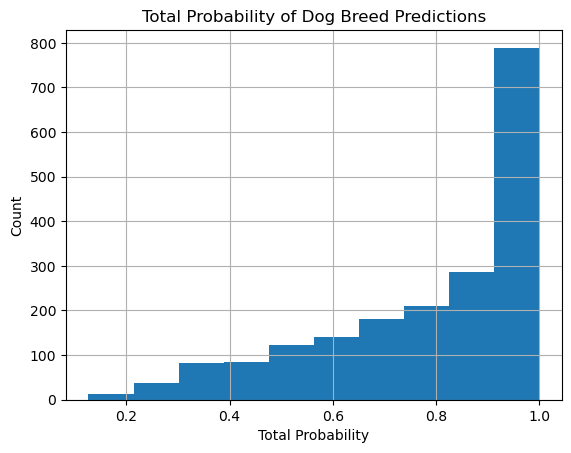

In [84]:
master_df.total_prob.hist()

plt.title('Total Probability of Dog Breed Predictions')
plt.xlabel('Total Probability')
plt.ylabel('Count')

## <a id='toc1_7_'></a>[Comedic Linear Regression Model for Engagement:](#toc0_)

In [85]:
master_df.select_dtypes(np.number).corr().retweet_count.sort_values(ascending=False)


retweet_count             1.000000
PR                        0.960931
favorite_count            0.928980
date_number               0.387929
doggo                     0.167990
img_num                   0.101612
puppo                     0.095593
p1_conf                   0.049165
total_prob                0.046803
hour                      0.046311
p1_conf_normalized        0.045100
p_dog_total               0.021571
p2_dog                    0.011697
p3_dog                    0.008235
floofer                   0.007188
p_dog_total_normalized    0.005504
p1_dog                    0.003465
p2_conf                  -0.014776
pupper                   -0.028921
p2_conf_normalized       -0.032314
p3_conf                  -0.040420
p3_conf_normalized       -0.054207
intercept                      NaN
Name: retweet_count, dtype: float64

In [86]:
predicted = 'PR'

predictors = [
    'intercept', 'date_number', 'p_dog_total', 'total_prob', 'doggo', 
    'puppo', 'pupper', 'floofer', '10/10', '11/10', '12/10', '13/10', 
    '14/10', 'high_dogs'
]

bool_columns = ['10/10', '11/10', '12/10', '13/10', '14/10', 'high_dogs']

for col in bool_columns:
    master_df[col] = master_df[col].astype('uint8')

print(master_df[predictors].dtypes)


intercept        int64
date_number      int32
p_dog_total    float64
total_prob     float64
doggo            uint8
puppo            uint8
pupper           uint8
floofer          uint8
10/10            uint8
11/10            uint8
12/10            uint8
13/10            uint8
14/10            uint8
high_dogs        uint8
dtype: object


In [87]:
results = sm.OLS(master_df[predicted], master_df[predictors]).fit()
print(results.summary())

lm_charts = pd.DataFrame({
    "coefficient": results.params.astype('int'),
    "lower_ci": results.conf_int()[0].astype('int'),
    "upper_ci": results.conf_int()[1].astype('int'),
    "std_err": results.bse.astype('int'),
    "p_value": results.pvalues 
})

lm_charts = lm_charts.sort_values(by='coefficient', ascending=False)

lm_charts


                            OLS Regression Results                            
Dep. Variable:                     PR   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     87.73
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          9.31e-184
Time:                        12:37:45   Log-Likelihood:                -20988.
No. Observations:                1946   AIC:                         4.200e+04
Df Residuals:                    1932   BIC:                         4.208e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     590.5849   1139.579      0.518      

,coefficient,lower_ci,upper_ci,std_err,p_value
14/10,16708,12271,21144,2262,2.239594e-13
13/10,10925,8621,13228,1174,3.650948e-20
high_dogs,6590,-3792,16973,5294,2.133397e-01
puppo,5605,728,10483,2486,2.429993e-02
doggo,3924,1183,6665,1397,5.031357e-03
12/10,2358,538,4179,928,1.111720e-02
total_prob,1604,-1373,4581,1518,2.909355e-01
11/10,799,-919,2517,876,3.618747e-01
intercept,590,-1644,2825,1139,6.043444e-01
10/10,489,-1144,2123,833,5.567339e-01


Text(0.5, 1.0, 'Which Tweet Characteristics are the Most Popular (Popularity Rating)')

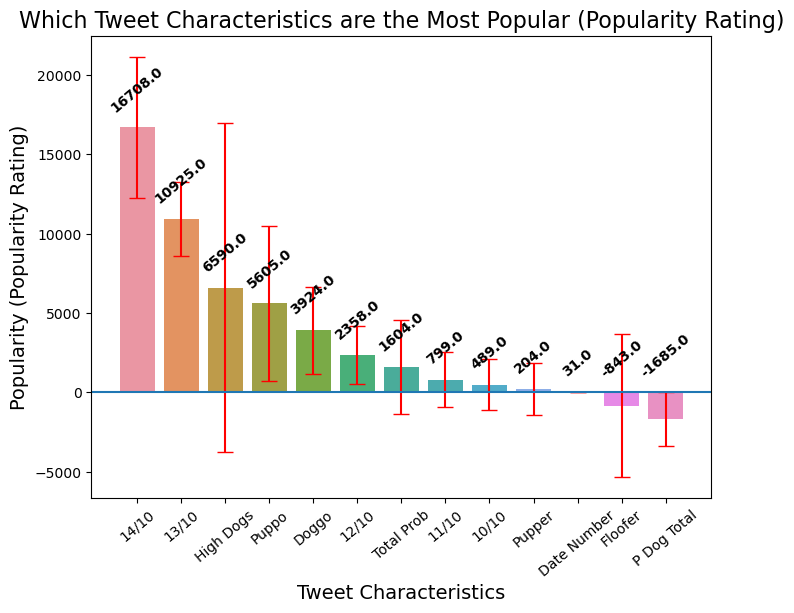

In [88]:
# graph = lm_charts.drop(index='intercept').loc[set(interest)].reset_index()
graph = lm_charts.drop(index=['intercept'])
lower_ci = graph['lower_ci']  
upper_ci = graph['upper_ci']  

# Set figure size
plt.figure(figsize=(8, 6))  

# Create bar plot
ax = sns.barplot(data=graph, x=graph.index, y='coefficient')

# Add error bars
ax.errorbar(graph.index, graph['coefficient'], color='red',
            yerr=[graph['coefficient'] - lower_ci, upper_ci - graph['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ) + 1000, f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)

# # Set custom labels
plt.xlabel("Tweet Characteristics", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=40, ticks=range(len(graph.index)), labels=graph.index.str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"Which Tweet Characteristics are the Most Popular (Popularity Rating)", fontsize=16)



In [89]:
predicted = 'PR'
ratings = ['10/10', '11/10', '12/10', '13/10', '14/10', 'high_dogs']
predictors = [ '10/10', '11/10', '12/10', '13/10', '14/10', 'high_dogs'] 


# results = sm.OLS(master_df[predicted], master_df[predictors]).fit()
# print(results.summary())

# lm_charts = pd.DataFrame(
#     {
#         "coefficient": results.params,
#         "lower_ci": results.conf_int()[0],
#         "upper_ci": results.conf_int()[1],
#         "std_err": results.bse,
#         "p_value": results.pvalues 
#     }
# )

# lm_charts = round(lm_charts.sort_values(by=f'coefficient', ascending=False), 6)

# lm_charts

# lm_charts.drop(index='intercept').loc[ratings].reset_index()


Text(0.5, 1.0, "The Impact of Ratings on Popularity Rating\nRelative to the Popularity of 'low-dogs'")

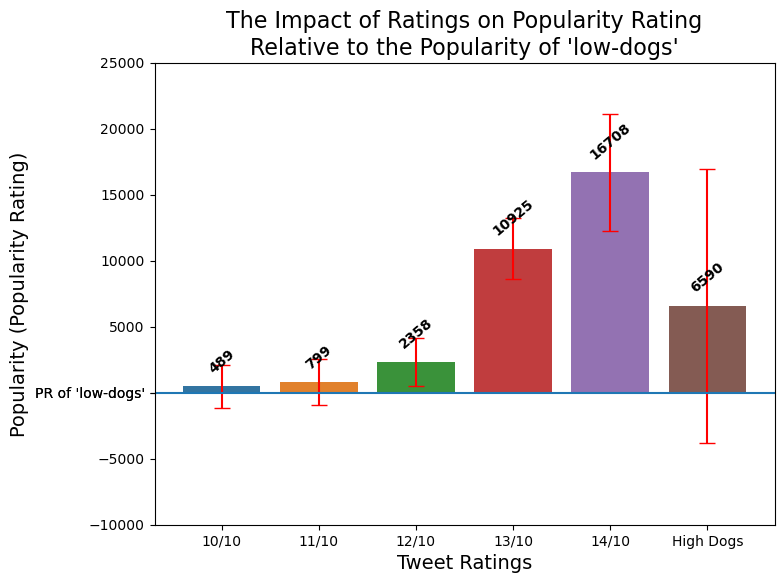

In [90]:

graph1 = lm_charts.loc[ratings].reset_index()

lower_ci = graph1['lower_ci']  
upper_ci = graph1['upper_ci']  

# Set figure size
plt.figure(figsize=(8, 6)) 

# Create bar plot
ax = sns.barplot(data=graph1, x='index', y='coefficient')

# Add error bars
ax.errorbar(graph1['index'], graph1['coefficient'], color='red',
            yerr=[graph1['coefficient'] - lower_ci, upper_ci - graph1['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph1.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ) + 1000, f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)


# Set y-ticks and labels
yticks = list(ax.get_yticks())
yticks.append(0)  
yticklabels = list(ax.get_yticklabels())
yticklabels.append("PR of 'low-dogs'")  
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# # Set custom labels
plt.xlabel("Tweet Ratings", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=0, ticks=range(len(graph1['index'])),labels=graph1['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"The Impact of Ratings on Popularity Rating\nRelative to the Popularity of 'low-dogs'", fontsize=16)


In [91]:
predicted = 'PR'
monikers = ['puppo', 'doggo', 'pupper', 'floofer']
predictors = [ 'puppo', 'doggo', 'pupper', 'floofer'] 


# results = sm.OLS(master_df[predicted], master_df[predictors]).fit()
# print(results.summary())

# lm_charts = pd.DataFrame(
#     {
#         "coefficient": results.params,
#         "lower_ci": results.conf_int()[0],
#         "upper_ci": results.conf_int()[1],
#         "std_err": results.bse,
#         "p_value": results.pvalues 
#     }
# )

# lm_charts = round(lm_charts.sort_values(by=f'coefficient', ascending=False), 6)

# lm_charts.drop(index='intercept').loc[monikers].reset_index()

Text(0.5, 1.0, 'The Impact of Monikers on Popularity Rating')

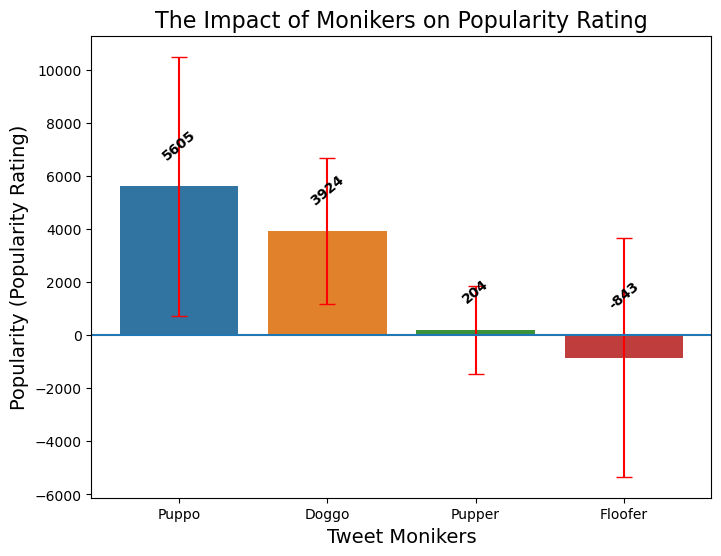

In [92]:
graph2 = lm_charts.loc[monikers].reset_index()

lower_ci = graph2['lower_ci']  
upper_ci = graph2['upper_ci']  

# Set figure size
plt.figure(figsize=(8, 6)) 

# Create bar plot
ax = sns.barplot(data=graph2, x='index', y='coefficient')

# Add error bars
ax.errorbar(graph2['index'], graph2['coefficient'], color='red',
            yerr=[graph2['coefficient'] - lower_ci, upper_ci - graph2['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph2.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ) + 1000, f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)

# # Set custom labels
plt.xlabel("Tweet Monikers", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=0, ticks=range(len(graph2['index'])),labels=graph2['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"The Impact of Monikers on Popularity Rating", fontsize=16)


In [93]:
predicted = 'PR'
probability_predictors = ['total_prob', 'p_dog_total', 'date_number'] 


# results = sm.OLS(master_df[predicted], master_df[predictors]).fit()
# print(results.summary())

# lm_charts = pd.DataFrame(
#     {
#         "coefficient": results.params,
#         "lower_ci": results.conf_int()[0],
#         "upper_ci": results.conf_int()[1],
#         "std_err": results.bse,
#         "p_value": results.pvalues 
#     }
# )

# lm_charts = round(lm_charts.sort_values(by=f'coefficient', ascending=False), 6)

# lm_charts
# lm_charts.drop(index='intercept').loc[predictors_no_intercept].reset_index()

Text(0.5, 1.0, 'The Impact of Ambiguity, Dogness, and Time on Popularity Rating')

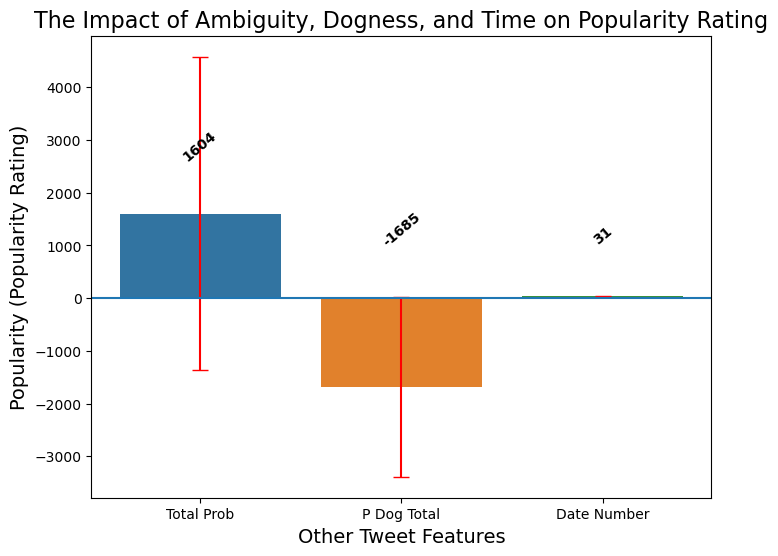

In [94]:
graph3 = lm_charts.loc[probability_predictors].reset_index()

lower_ci = graph3['lower_ci']  
upper_ci = graph3['upper_ci']  

# Set figure size
plt.figure(figsize=(8, 6)) 

# Create bar plot
ax = sns.barplot(data=graph3, x='index', y='coefficient')

# Add error bars
ax.errorbar(graph3['index'], graph3['coefficient'], color='red',
            yerr=[graph3['coefficient'] - lower_ci, upper_ci - graph3['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph3.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ) + 1000, f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)

# # Set custom labels
plt.xlabel("Other Tweet Features", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=0, ticks=range(len(graph3['index'])),labels=graph3['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"The Impact of Ambiguity, Dogness, and Time on Popularity Rating", fontsize=16)


tweet_id                                                 744234799360020481
timestamp                                         2016-06-18 18:26:18+00:00
source                                                               iPhone
text                      Here's a doggo realizing you can stand in a po...
expanded_urls             https://twitter.com/dog_rates/status/744234799...
name                                                                    NaN
doggo                                                                     1
floofer                                                                   0
pupper                                                                    0
puppo                                                                     0
retweet_count                                                       68769.0
favorite_count                                                     140268.0
jpg_url                   https://pbs.twimg.com/ext_tw_video_thumb/74423...
img_num     

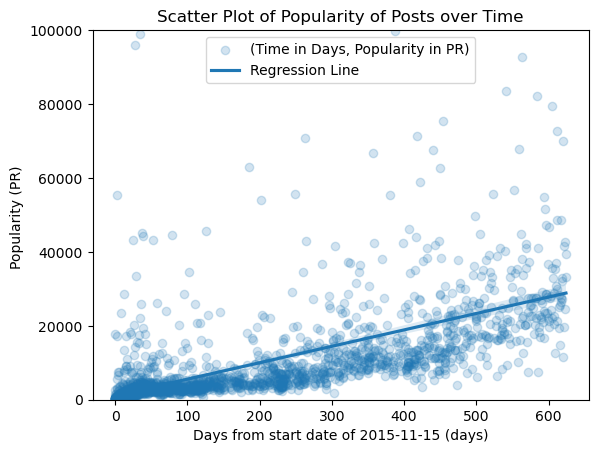

In [95]:
sns.regplot(data=master_df, x='date_number', y='PR', scatter_kws={'alpha':0.2})
plt.xlabel('Days from start date of 2015-11-15 (days)')
plt.ylabel('Popularity (PR) ')
plt.title('Scatter Plot of Popularity of Posts over Time')
plt.ylim(0, 100000)
plt.legend(['(Time in Days, Popularity in PR)','Regression Line'])

master_df.loc[master_df.PR.idxmax()]

(493, 1453)

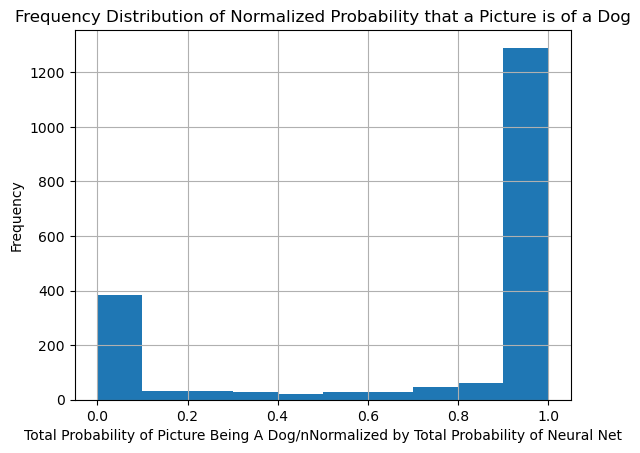

In [96]:

master_df['p_dog_total_normalized'].hist() 

plt.xlabel('Total Probability of Picture Being A Dog/nNormalized by Total Probability of Neural Net')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Normalized Probability that a Picture is of a Dog')

master_df.query('p_dog_total_normalized < 0.5').text.count(), master_df.query('p_dog_total_normalized >= 0.5').text.count()

## <a id='toc1_8_'></a>[Setting up Dog Breed Columns](#toc0_)

In [97]:
# # I didn't want any non-dogs in my breeds group,
# So I used the normalized probability of a picture being a dog to filter out non-dogs 
# I also visually checked the resulting df for any non-dog breeds that had over 30 samples in the data
common_breeds =  master_df.query('p_dog_total_normalized > .8')

# amount of instances when a specific dog breed was predicted in columns p1, p2, or p3
common_breeds_df = pd.concat([common_breeds.p1.value_counts(), common_breeds.p2.value_counts(), \
            common_breeds.p3.value_counts()], axis = 1)

common_breeds_df = common_breeds_df.fillna(0)

common_breeds_df['totals'] = common_breeds_df.sum(axis=1)

common_breeds_df = common_breeds_df.query('totals > 30').sort_values('totals', ascending=False)

common_breeds_df, common_breeds.shape

(                                count  count  count  totals
 labrador_retriever               83.0   85.0   61.0   229.0
 golden_retriever                130.0   64.0   34.0   228.0
 chihuahua                        66.0   31.0   50.0   147.0
 pembroke                         84.0   19.0   19.0   122.0
 cardigan                         16.0   69.0   17.0   102.0
 pomeranian                       35.0   36.0   22.0    93.0
 toy_poodle                       32.0   26.0   22.0    80.0
 french_bulldog                   23.0   33.0   23.0    79.0
 chow                             36.0   17.0   24.0    77.0
 pug                              51.0   13.0   12.0    76.0
 cocker_spaniel                   25.0   27.0   24.0    76.0
 chesapeake_bay_retriever         21.0   33.0   20.0    74.0
 eskimo_dog                       16.0   25.0   30.0    71.0
 beagle                           17.0   27.0   23.0    67.0
 siberian_husky                   17.0   32.0   14.0    63.0
 staffordshire_bullterri

In [98]:
# I then assigned the index of the resulting df to a variable
common_breeds_index = common_breeds_df.index

common_breeds_index[:5]

Index(['labrador_retriever', 'golden_retriever', 'chihuahua', 'pembroke',
       'cardigan'],
      dtype='object')

In [99]:
def likely_this_dog(columns_to_cheeck=['p1', 'p2', 'p3'], prob=True, count=False, master_df=master_df): 

    df = pd.DataFrame()
    dummy_columns = pd.DataFrame(columns=common_breeds_index)
    for h, i in enumerate(columns_to_cheeck):
        # take all rows that have dog breeds in the common_breeds_index and the column for p1, p2, or p3
        # then turn those values in the columns into dummy variables and place them in a dataframe
        # fill in the nan values with 0's
        if prob == True:
            dummy_columns = pd.get_dummies(master_df.loc[master_df[i].isin(common_breeds_index), i])\
              .apply(lambda x: x * master_df[f'{i}_conf'])
        else:
            dummy_columns = pd.get_dummies(master_df.loc[master_df[i].isin(common_breeds_index), i])

        if count == True:
            df[f'{i}'] = dummy_columns.sum().sort_values(ascending=False)
        
        else:
            # sum all the values in the first dummy table with the other dummy table values
            # if one side has a nan and the other has a int, group them by index, then replace it with the int
            df = pd.concat([df, dummy_columns]).reset_index().groupby('index', sort=False).sum(min_count=1)

    # Convert the dataframe to float64
    df = df.astype('float64')
    
    return df

likely_this_dog(count=True).sum(axis=1).sort_values(ascending=False).head(), likely_this_dog().sum().sort_values(ascending=False).head()


(golden_retriever      114.808473
 labrador_retriever     73.318708
 pembroke               68.329117
 chihuahua              53.035569
 pug                    43.750687
 dtype: float64,
 golden_retriever      114.808473
 labrador_retriever     73.318708
 pembroke               68.329117
 chihuahua              53.035569
 pug                    43.750687
 dtype: float64)

In [100]:
likely_this_dog()

,american_staffordshire_terrier,beagle,border_collie,boston_bull,boxer,bull_mastiff,cardigan,chesapeake_bay_retriever,chihuahua,chow,cocker_spaniel,collie,eskimo_dog,french_bulldog,german_shepherd,golden_retriever,great_pyrenees,italian_greyhound,kelpie,kuvasz,labrador_retriever,lakeland_terrier,malamute,maltese_dog,miniature_pinscher,miniature_poodle,norwegian_elkhound,pekinese,pembroke,pomeranian,pug,rottweiler,samoyed,shetland_sheepdog,shih_tzu,siberian_husky,staffordshire_bullterrier,tibetan_mastiff,toy_poodle,toy_terrier,west_highland_white_terrier
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.156665,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.061428,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.074192,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.596461,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.222752,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.560311,0.0,0.0,0.000000,0.0,0.0,0.0,0.243682,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.168086,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.716012,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.031379,0.0,0.000000,0.0,0.078253,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
dog_breeds = likely_this_dog().fillna(0)
dog_breeds['uncommon_breeds'] = master_df.p_dog_total - dog_breeds[common_breeds_index].sum(axis=1)
dog_breeds = pd.concat([master_df[['doggo', 'floofer', 'pupper', 'puppo', 'date_number', 'intercept']], dog_breeds], axis=1 ).fillna(0)

dog_breeds.info()

dog_breeds

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 2355
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   doggo                           1946 non-null   uint8  
 1   floofer                         1946 non-null   uint8  
 2   pupper                          1946 non-null   uint8  
 3   puppo                           1946 non-null   uint8  
 4   date_number                     1946 non-null   int32  
 5   intercept                       1946 non-null   int64  
 6   american_staffordshire_terrier  1946 non-null   float64
 7   beagle                          1946 non-null   float64
 8   border_collie                   1946 non-null   float64
 9   boston_bull                     1946 non-null   float64
 10  boxer                           1946 non-null   float64
 11  bull_mastiff                    1946 non-null   float64
 12  cardigan                        1946 no

,doggo,floofer,pupper,puppo,date_number,intercept,american_staffordshire_terrier,beagle,border_collie,boston_bull,boxer,bull_mastiff,cardigan,chesapeake_bay_retriever,chihuahua,chow,cocker_spaniel,collie,eskimo_dog,french_bulldog,german_shepherd,golden_retriever,great_pyrenees,italian_greyhound,kelpie,kuvasz,labrador_retriever,lakeland_terrier,malamute,maltese_dog,miniature_pinscher,miniature_poodle,norwegian_elkhound,pekinese,pembroke,pomeranian,pug,rottweiler,samoyed,shetland_sheepdog,shih_tzu,siberian_husky,staffordshire_bullterrier,tibetan_mastiff,toy_poodle,toy_terrier,west_highland_white_terrier,uncommon_breeds
0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.156665,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.061428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465074
1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.074192,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.578836
2,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.596461,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254781
3,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.222752,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768830
4,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.560311,0.0,0.0,0.000000,0.0,0.0,0.0,0.243682,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,0,0,0,0,621,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.956701
2352,0,0,0,0,622,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.168086,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2353,0,0,0,0,623,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.716012,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.031379,0.0,0.000000,0.0,0.078253,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2354,0,0,0,0,624,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323581,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090647,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068957


### <a id='toc1_8_1_'></a>[Setting up for Logistic Regression analysis on Dog Breeds and Monikers](#toc0_)



In [102]:
def vif(dependent='PR', df=dog_breeds):
    # this list comprehension of list comprehension gives every column name that we are interested evaluating
    dog_title_str = str([i for i in [i for i in df.columns] if i not in [dependent]])\
        .replace('\n', '').replace('\', \'', ' + ').strip('\'[]')

    y, X = dmatrices(f'{dependent} ~ {dog_title_str}', df, return_type='dataframe')

    vif = pd.DataFrame()
    vif["features"] = X.columns

    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by='VIF Factor', ascending=False)

    return vif

# for i in monikers:
#     print(f"VIF for {i}:", vif(i).head(15), '\n')


In [103]:

for i in monikers:
    dog_breeds.query(f'{i}==1').mean()

    dog_breeds.mean()[dog_breeds.query(f'{i}==1').mean()>0.001].index

    dog_list = list(dog_breeds.drop(monikers, axis=1).mean()[dog_breeds.query(f'{i}==1').applymap(lambda x: 1 if x > 0 else 0).sum()>1].index)
    print(dog_list)


['date_number', 'intercept', 'cardigan', 'chow', 'eskimo_dog', 'golden_retriever', 'italian_greyhound', 'kelpie', 'labrador_retriever', 'malamute', 'pembroke', 'siberian_husky', 'uncommon_breeds']
['date_number', 'intercept', 'border_collie', 'boston_bull', 'chesapeake_bay_retriever', 'chihuahua', 'cocker_spaniel', 'collie', 'eskimo_dog', 'french_bulldog', 'german_shepherd', 'golden_retriever', 'great_pyrenees', 'kelpie', 'kuvasz', 'labrador_retriever', 'norwegian_elkhound', 'pekinese', 'pembroke', 'pomeranian', 'siberian_husky', 'staffordshire_bullterrier', 'tibetan_mastiff', 'west_highland_white_terrier', 'uncommon_breeds']
['date_number', 'intercept', 'american_staffordshire_terrier', 'beagle', 'border_collie', 'boston_bull', 'boxer', 'bull_mastiff', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'cocker_spaniel', 'collie', 'eskimo_dog', 'french_bulldog', 'german_shepherd', 'golden_retriever', 'great_pyrenees', 'italian_greyhound', 'kelpie', 'kuvasz', 'labrador_retriev

In [104]:

def logit(dependent='doggo', model_testing=False): 
    # setup model, all the dog breeds were required to have at least one instance of being the moniker. Or else the model wouldn't work??
    dependent_group = ['doggo', 'floofer', 'pupper', 'puppo']
    dog_title_list = list(dog_breeds.drop(dependent_group, axis=1).mean()[dog_breeds.query(f'{i}==1').applymap(lambda x: 1 if x > 0 else 0).sum()>2].index)
    
    logit_mod = sm.Logit(dog_breeds[dependent], dog_breeds[dog_title_list])
   
    #fit the model
    results = logit_mod.fit()

    #get summary statistics
    print(results.summary2())

    odds_ratios = pd.DataFrame(
        {
            f"{dependent}_odds_ratio": results.params,
            "lower_ci": results.conf_int()[0],
            "upper_ci": results.conf_int()[1],
            "std_err": results.bse

        }
        
    )
    odds_ratios = np.exp(odds_ratios)
    odds_ratios["p_value"] = results.pvalues

    odds_ratios = round(odds_ratios.sort_values(by=f"{dependent}_odds_ratio", ascending=False), 4)

    if model_testing==True:
        y = dog_breeds[dependent]
        X = dog_breeds[dog_title_list]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.10, random_state=42)
        
        log_mod = LogisticRegression()
        log_mod.fit(X_train, y_train)
        y_preds = log_mod.predict(X_test)

        matrix = []
        matrix.append(confusion_matrix(y_test, y_preds))
        print(precision_score(y_test, y_preds))
        print(recall_score(y_test, y_preds))
        print(accuracy_score(y_test, y_preds))
        return odds_ratios, matrix
    
    return odds_ratios



In [105]:
monikers

['puppo', 'doggo', 'pupper', 'floofer']

In [106]:
monikers = ['doggo', 'pupper', 'puppo', 'floofer']

dfs_of_logit = []
matrixes = []
for i in monikers:
    print(f"Logistic Regression for {i} is:") 
    logitreg, matrixes_confusion = logit(i, model_testing=True)
    print()
    dfs_of_logit.append(logitreg)
    matrixes.append(matrixes_confusion)




Logistic Regression for doggo is:
Optimization terminated successfully.
         Current function value: inf
         Iterations 9
                              Results: Logit
Model:                   Logit                Method:               MLE   
Dependent Variable:      doggo                Pseudo R-squared:     inf   
Date:                    2023-08-14 12:37     AIC:                  inf   
No. Observations:        1946                 BIC:                  inf   
Df Model:                14                   Log-Likelihood:       -inf  
Df Residuals:            1931                 LL-Null:              0.0000
Converged:               1.0000               LLR p-value:          1.0000
No. Iterations:          9.0000               Scale:                1.0000
--------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
--------------------------------------------------------------------------

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWa

                                 Results: Logit
Model:                     Logit                  Method:                 MLE   
Dependent Variable:        pupper                 Pseudo R-squared:       inf   
Date:                      2023-08-14 12:37       AIC:                    inf   
No. Observations:          1946                   BIC:                    inf   
Df Model:                  40                     Log-Likelihood:         -inf  
Df Residuals:              1905                   LL-Null:                0.0000
Converged:                 1.0000                 LLR p-value:            1.0000
No. Iterations:            8.0000                 Scale:                  1.0000
--------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
--------------------------------------------------------------------------------
date_number                    -0.0017   0.0005  -3.8109 0.00

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\ProgramData\Anaconda3\lib\site-

In [107]:
dfs_of_logit[0]

,doggo_odds_ratio,lower_ci,upper_ci,std_err,p_value
great_pyrenees,7.0051,0.7403,66.2810,3.1474,0.0896
german_shepherd,4.5252,0.6322,32.3928,2.7298,0.1328
norwegian_elkhound,3.0506,0.1111,83.7296,5.4193,0.5093
siberian_husky,2.9290,0.0928,92.4136,5.8186,0.5417
golden_retriever,2.8415,1.1527,7.0045,1.5846,0.0233
cocker_spaniel,1.9492,0.1165,32.6216,4.2104,0.6424
labrador_retriever,1.8911,0.5058,7.0700,1.9598,0.3437
uncommon_breeds,1.6838,0.7425,3.8184,1.5185,0.2123
eskimo_dog,1.6513,0.0210,129.8233,9.2709,0.8218
chesapeake_bay_retriever,1.3778,0.0795,23.8793,4.2861,0.8257


In [108]:
base_rate = dfs_of_logit[0].loc['intercept', dfs_of_logit[0].columns[0]]
base_rate, monikers

(0.0102, ['doggo', 'pupper', 'puppo', 'floofer'])

In [109]:

def chart_breed_moniker(chart_number=0, nicknames = monikers):
    # setting up data for graphs
    odds_ratio_column = dfs_of_logit[chart_number].columns[0]
    base_rate = dfs_of_logit[chart_number].loc['intercept', odds_ratio_column]
    graph_chart = dfs_of_logit[chart_number].drop(index='intercept').reset_index()
    never_occur = sorted(list(set(common_breeds_index).difference(set(graph_chart['index']))))

    # Convert to logarithmic scale  
    lower_ci = graph_chart['lower_ci']
    upper_ci = graph_chart['upper_ci']

    # Set figure size
    fig, ax = plt.subplots(figsize=(20, 5)) 
    plt.ylim(0.005, 500)

    # Create bar plot
    ax = sns.barplot(data=graph_chart, x='index', y=odds_ratio_column)
    
    # Add error bars
    ax.errorbar(x = graph_chart['index'], y = graph_chart[odds_ratio_column], color='red', fmt='none', capsize=6,
                yerr=[graph_chart[odds_ratio_column] - lower_ci, upper_ci - graph_chart[odds_ratio_column]])
    
    # Set y-axis scale to logarithmic
    ax.set_yscale('log') 
    
    # Set custom y-axis ticks and labels
    ax.set_yticks([.01, round(np.sqrt(10)/100, 3), 0.1, np.sqrt(10)/10, 1, np.sqrt(10), 10, np.sqrt(10)*10, 100, np.sqrt(10)*100])  
    ax.set_yticklabels([.01, round(np.sqrt(10)/100, 3), '0.1', round(np.sqrt(10)/10, 3), \
            f'Base Rate =\n{round(base_rate * 100, 2)}%', round(np.sqrt(10), 2), '10', str(round(np.sqrt(10), 2)*10), '100', str(round(np.sqrt(10)*100, 2))])  

    plt.xlabel("Dog Breeds", fontsize=14)
    plt.ylabel(f"Odds Ratio of Being Called a '{nicknames[chart_number]}'", fontsize=14)
    plt.xticks(rotation=90, ticks=np.arange(len(graph_chart)), labels=graph_chart['index'].str.replace('_', " ").str.title())
    plt.axhline(1)
    plt.title(f"Which Common Dog Breed is more likely to be called a '{nicknames[chart_number]}'", fontsize=16)
    # Add labels to the bars
    for i, row in graph_chart.iterrows():
        ax.text(i, row[odds_ratio_column] + row[odds_ratio_column]*.2, f"{round(row[odds_ratio_column], 2)}x", ha='center', weight='bold', rotation=45)
    
    print(f"Common Breeds that are Never called '{nicknames[chart_number]}' in the Current Sample:")
    for i in range(-(-len(never_occur)//3)):
        print_three = ', '.join([i.title().replace('_', ' ') for i in never_occur[i*3 : i*3 +3]])
        print(print_three)
        

Common Breeds that are Never called 'doggo' in the Current Sample:
American Staffordshire Terrier, Beagle, Border Collie
Boston Bull, Boxer, Bull Mastiff
Cardigan, Chow, Collie
French Bulldog, Italian Greyhound, Kuvasz
Lakeland Terrier, Malamute, Maltese Dog
Miniature Pinscher, Miniature Poodle, Pekinese
Pomeranian, Pug, Rottweiler
Samoyed, Shetland Sheepdog, Shih Tzu
Staffordshire Bullterrier, Tibetan Mastiff, Toy Poodle
Toy Terrier, West Highland White Terrier


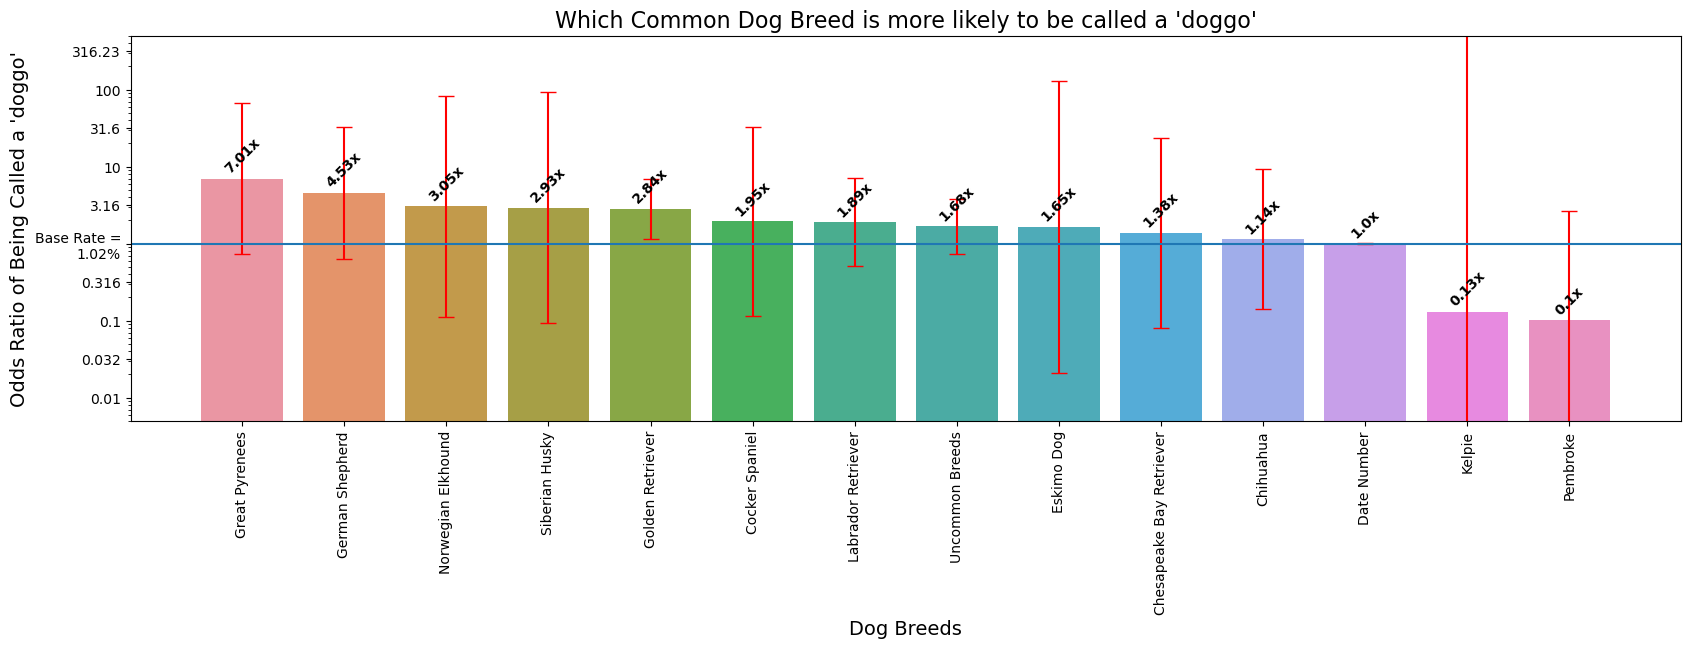

In [110]:
chart_breed_moniker(0)

Common Breeds that are Never called 'pupper' in the Current Sample:
Italian Greyhound, Rottweiler, West Highland White Terrier


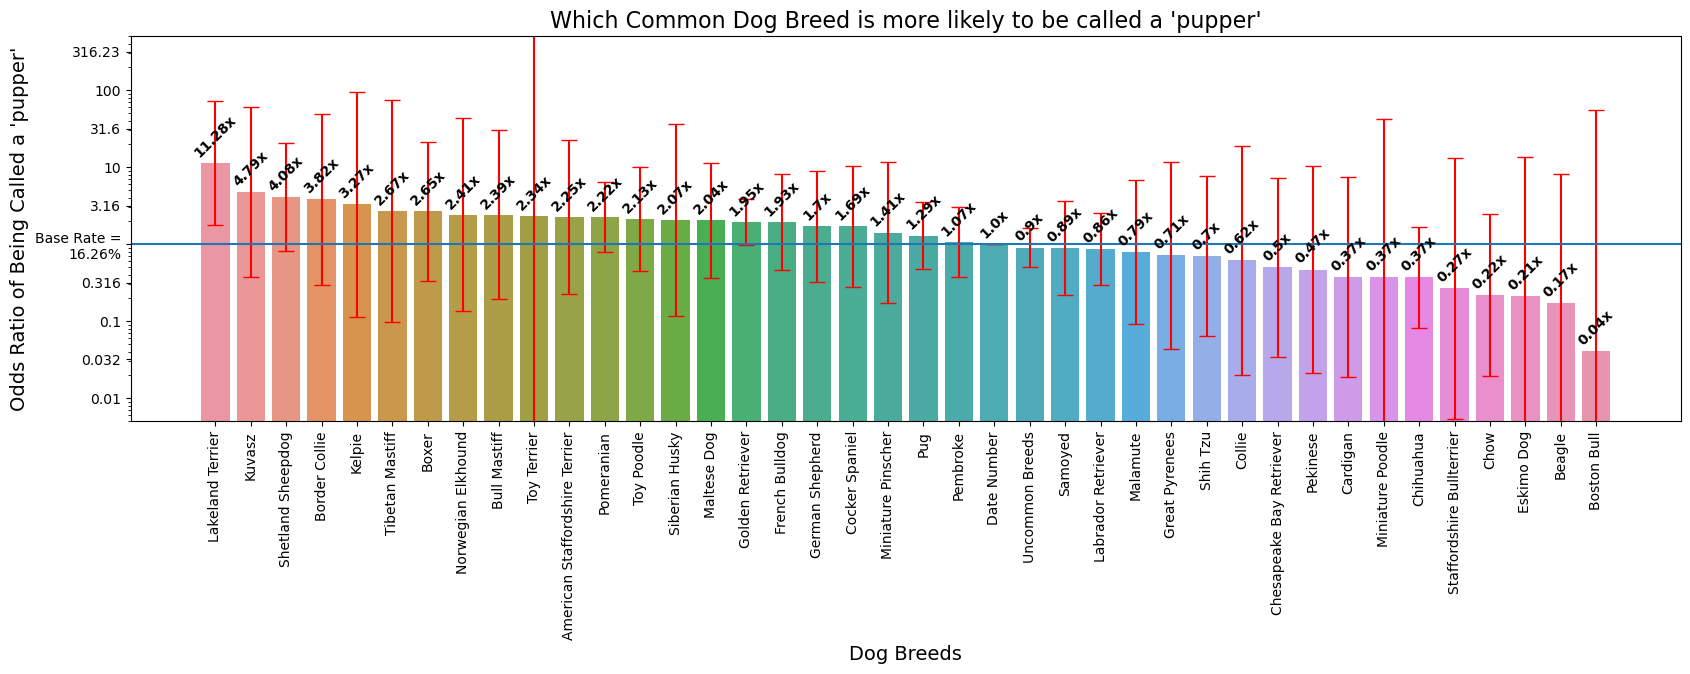

In [111]:
chart_breed_moniker(1)


Common Breeds that are Never called 'puppo' in the Current Sample:
American Staffordshire Terrier, Beagle, Border Collie
Boston Bull, Boxer, Bull Mastiff
Cardigan, Chesapeake Bay Retriever, Chihuahua
Chow, Cocker Spaniel, Collie
French Bulldog, German Shepherd, Great Pyrenees
Italian Greyhound, Kelpie, Kuvasz
Lakeland Terrier, Maltese Dog, Miniature Pinscher
Miniature Poodle, Norwegian Elkhound, Pekinese
Pomeranian, Pug, Rottweiler
Samoyed, Shetland Sheepdog, Shih Tzu
Staffordshire Bullterrier, Tibetan Mastiff, Toy Poodle
Toy Terrier, West Highland White Terrier


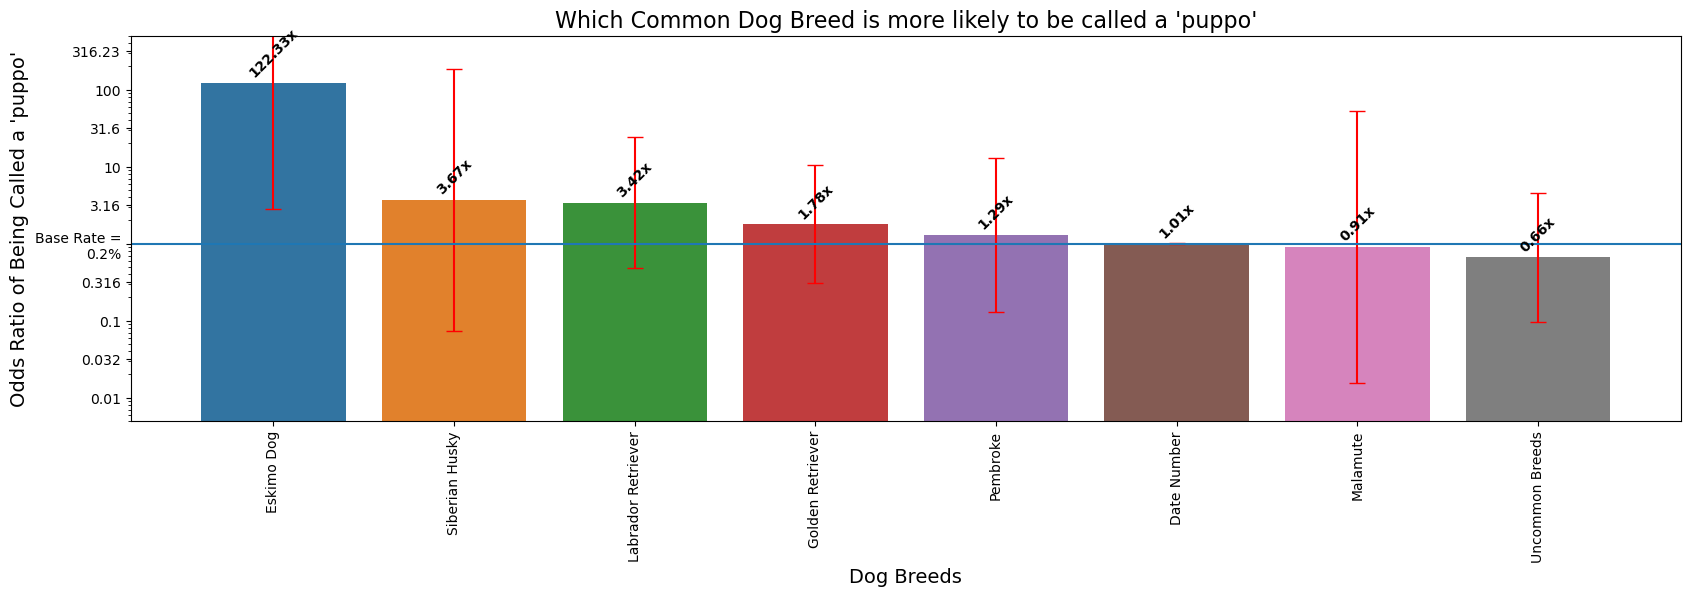

In [112]:
chart_breed_moniker(2)

Common Breeds that are Never called 'floofer' in the Current Sample:
American Staffordshire Terrier, Beagle, Border Collie
Boston Bull, Boxer, Bull Mastiff
Cardigan, Chesapeake Bay Retriever, Chihuahua
Cocker Spaniel, Collie, Eskimo Dog
French Bulldog, German Shepherd, Great Pyrenees
Italian Greyhound, Kelpie, Lakeland Terrier
Malamute, Maltese Dog, Miniature Pinscher
Miniature Poodle, Norwegian Elkhound, Pekinese
Pug, Rottweiler, Shetland Sheepdog
Shih Tzu, Siberian Husky, Staffordshire Bullterrier
Toy Poodle, Toy Terrier, West Highland White Terrier


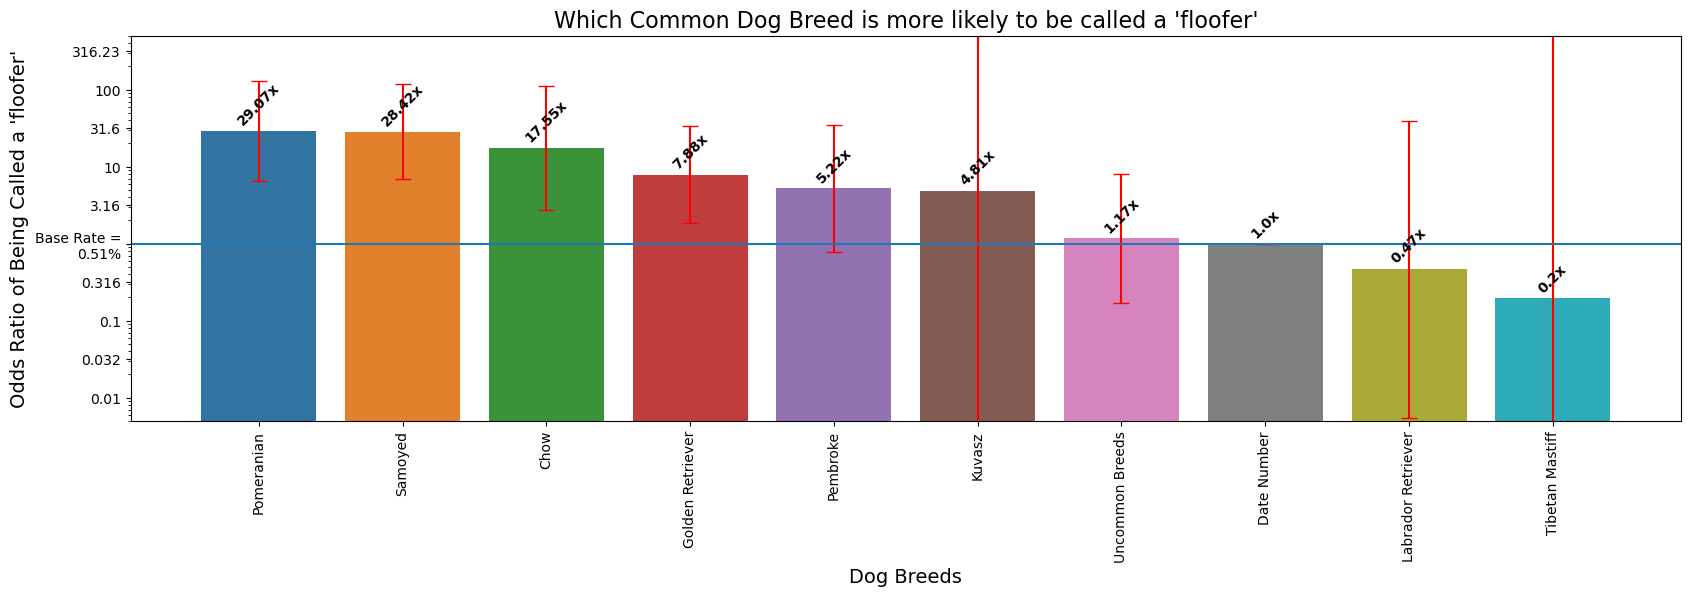

In [113]:
chart_breed_moniker(3)


## <a id='toc1_9_'></a>[Predict the Popularity Ratings from Breed](#toc0_)

Use count of dog breed present in top 3 predictions to predict rating.

In [114]:
# counted_dog_breeds = likely_this_dog()
# counted_dog_breeds['uncommon_breeds'] = master_df.p_dog_total - counted_dog_breeds[common_breeds_index].sum(axis=1)
# counted_dog_breeds = counted_dog_breeds.applymap(lambda x: 1 if x > 0 else 0)
# counted_dog_breeds['intercept'] = 1
# counted_dog_breeds = pd.concat([master_df['PR'], counted_dog_breeds], axis=1 ).fillna(0)

# dog_breeds = counted_dog_breeds

# counted_dog_breeds

Use likelihood of dog breed to predict rating.

In [115]:
dog_picts_df = pd.concat([dog_breeds, master_df[["PR", "img_num"]]], axis=1)
dog_picts_df.head() 


,doggo,floofer,pupper,puppo,date_number,intercept,american_staffordshire_terrier,beagle,border_collie,boston_bull,boxer,bull_mastiff,cardigan,chesapeake_bay_retriever,chihuahua,chow,cocker_spaniel,collie,eskimo_dog,french_bulldog,german_shepherd,golden_retriever,great_pyrenees,italian_greyhound,kelpie,kuvasz,labrador_retriever,lakeland_terrier,malamute,maltese_dog,miniature_pinscher,miniature_poodle,norwegian_elkhound,pekinese,pembroke,pomeranian,pug,rottweiler,samoyed,shetland_sheepdog,shih_tzu,siberian_husky,staffordshire_bullterrier,tibetan_mastiff,toy_poodle,toy_terrier,west_highland_white_terrier,uncommon_breeds,PR,img_num
0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156665,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.061428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465074,2623.0,1.0
1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074192,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.578836,148.0,1.0
2,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.596461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254781,131.0,1.0
3,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222752,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768830,351.0,1.0
4,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560311,0.0,0.0,0.0,0.0,0.0,0.0,0.243682,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154629,121.0,1.0


In [116]:
vif(df=dog_picts_df).head()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,features,VIF Factor
42,siberian_husky,1.737750
19,eskimo_dog,1.735803
45,toy_poodle,1.348883
32,miniature_poodle,1.325116
48,uncommon_breeds,1.240312


In [117]:
dog_picts_df.corr().PR.sort_values()

uncommon_breeds                  -0.055682
pupper                           -0.043060
pug                              -0.041933
maltese_dog                      -0.036279
shih_tzu                         -0.036275
miniature_poodle                 -0.027859
beagle                           -0.027012
boxer                            -0.022257
kuvasz                           -0.021707
bull_mastiff                     -0.021003
west_highland_white_terrier      -0.020747
italian_greyhound                -0.019557
collie                           -0.016029
toy_poodle                       -0.014672
lakeland_terrier                 -0.013840
miniature_pinscher               -0.010294
american_staffordshire_terrier   -0.008806
chihuahua                        -0.008373
pekinese                         -0.006500
staffordshire_bullterrier        -0.004564
rottweiler                       -0.004435
shetland_sheepdog                -0.002004
german_shepherd                  -0.001517
pomeranian 

In [118]:
lm = sm.OLS(dog_picts_df['PR'], dog_picts_df[list(set(dog_picts_df.columns) - {'PR'})])
results = lm.fit()
print(results.summary())


er_linear_regression = pd.DataFrame(
    {
        "coefficient": results.params.astype('int'),
        "lower_ci": results.conf_int()[0].astype('int'),
        "upper_ci": results.conf_int()[1].astype('int'),
        "std_err": results.bse.astype('int'),
        "p_value": results.pvalues 
    }
)

er_linear_regression = round(er_linear_regression.sort_values(by=f'coefficient', ascending=False), 6)
er_linear_regression.head()


                            OLS Regression Results                            
Dep. Variable:                     PR   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     20.29
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          5.28e-136
Time:                        12:37:53   Log-Likelihood:                -21037.
No. Observations:                1946   AIC:                         4.217e+04
Df Residuals:                    1897   BIC:                         4.244e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
floofer     

,coefficient,lower_ci,upper_ci,std_err,p_value
eskimo_dog,9380,-3668,22429,6653,0.158741
puppo,6758,1611,11904,2624,0.010087
great_pyrenees,6525,-3034,16085,4874,0.180838
toy_terrier,5026,-20463,30516,12996,0.698975
doggo,4898,2057,7738,1448,0.000734


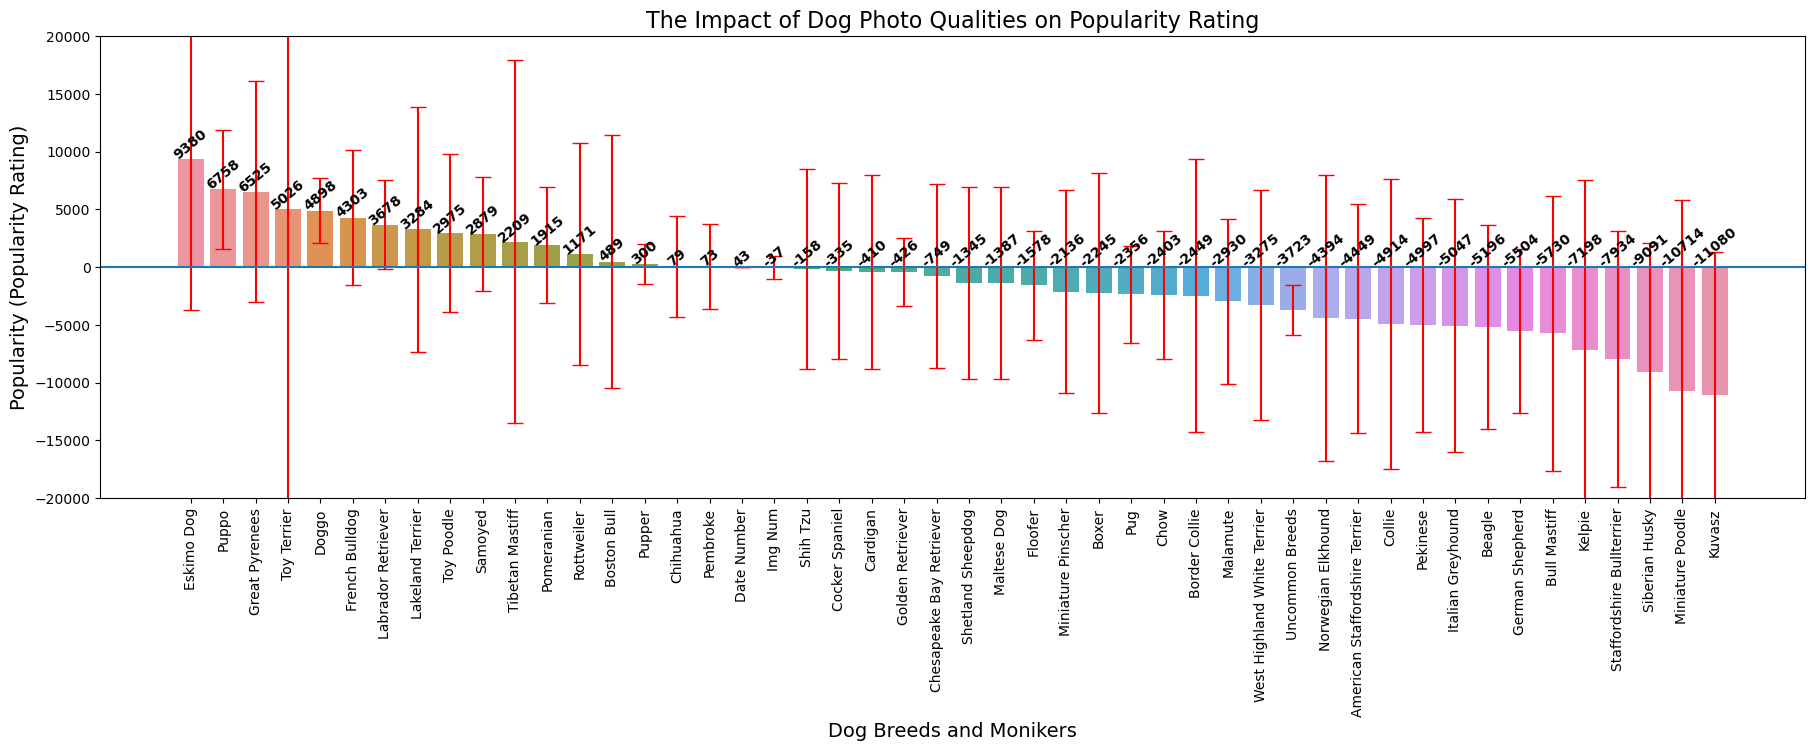

In [119]:
graph4 = er_linear_regression.drop(index=['intercept']).reset_index()

lower_ci = graph4['lower_ci']  
upper_ci = graph4['upper_ci']  
p_value = graph4['p_value']

# Set figure size
plt.figure(figsize=(22, 6)) 

# Create bar plot
ax = sns.barplot(data=graph4, x='index', y='coefficient')
ax.set_ylim(-20000, 20000)

# Add error bars
ax.errorbar(graph4['index'], graph4['coefficient'], color='red',
            yerr=[graph4['coefficient'] - lower_ci, upper_ci - graph4['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph4.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ), f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)

# Set y-ticks and labels
plt.xlabel("Dog Breeds and Monikers", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=90, ticks= range(len(graph4['index'])), labels=graph4['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"The Impact of Dog Photo Qualities on Popularity Rating", fontsize=16); 


Text(0.5, 1.0, 'Popularity Rating of Different Photo Qualities\nStatistically Significant Version')

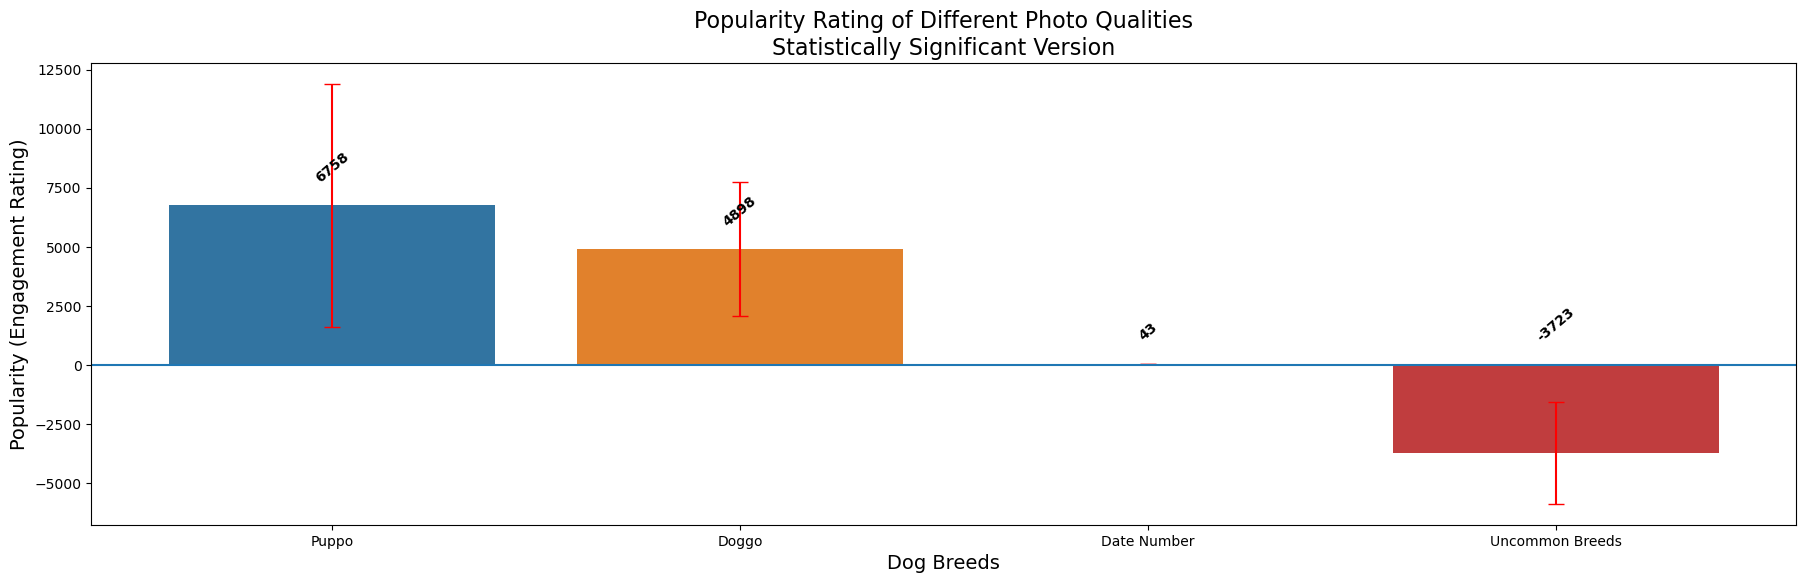

In [120]:
graph5 = graph4.query('p_value < 0.05').reset_index(drop=True)

lower_ci = graph5['lower_ci']  
upper_ci = graph5['upper_ci']  

# Set figure size
plt.figure(figsize=(22, 6)) 

# Create bar plot
ax = sns.barplot(data=graph5, x='index', y='coefficient')

# Add error bars
ax.errorbar(graph5['index'], graph5['coefficient'], color='red',
            yerr=[graph5['coefficient'] - lower_ci, upper_ci - graph5['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph5.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ) + 1000, f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)


# Set y-ticks and labels
plt.xlabel("Dog Breeds", fontsize=14)
plt.ylabel(f"Popularity (Engagement Rating)", fontsize=14)
plt.xticks(rotation=0, ticks= range(len(graph5['index'])), labels=graph5['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"Popularity Rating of Different Photo Qualities\nStatistically Significant Version", fontsize=16)




## <a id='toc1_10_'></a>[Multiple Linear Regression Model for Engagement:](#toc0_)

In [121]:
final_df = likely_this_dog().fillna(0)
final_df['uncommon_breeds'] = master_df.p_dog_total - dog_picts_df[common_breeds_index].sum(axis=1)

final_df = pd.concat([master_df, final_df], axis=1).copy()
final_df.info()

final_df.uncommon_breeds.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 2355
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   tweet_id                        1946 non-null   object             
 1   timestamp                       1946 non-null   datetime64[ns, UTC]
 2   source                          1946 non-null   object             
 3   text                            1946 non-null   object             
 4   expanded_urls                   1946 non-null   object             
 5   name                            1434 non-null   object             
 6   doggo                           1946 non-null   uint8              
 7   floofer                         1946 non-null   uint8              
 8   pupper                          1946 non-null   uint8              
 9   puppo                           1946 non-null   uint8              
 10  retweet_count    

uncommon_breeds
 0.000000e+00    1061
 1.110223e-16      33
-1.110223e-16      24
 5.551115e-17       2
 4.650740e-01       1
                 ... 
 4.563420e-01       1
 6.517470e-02       1
 9.956176e-01       1
 9.671380e-03       1
 6.895690e-02       1
Name: count, Length: 830, dtype: int64

In [122]:
# ['intercept', 'p_dog_total', 'total_prob', 'doggo', 'puppo', 'pupper', 'floofer', '10/10', '11/10', '12/10', '13/10', '14/10', 'high_dogs'] 

# best_predictors = ['intercept', 'date_number', 'doggo', 'puppo', '12/10', '13/10', '14/10'] # removed pupper, floofer, p_dog_total, # 10/10, 11/10, low_dogs is baseline,   'hour', 'total_prob', 

# ['intercept', 'date_number', 'p_dog_total', 'doggo', 'puppo', 'pupper', 'floofer', '10/10', '11/10', '12/10', '13/10', '14/10', 'high_dogs'] 

final_df.columns

all_characteristics = ['intercept', 'doggo', 'floofer', 'pupper', 'puppo', 'img_num', 'total_prob',
       'p_dog_total_normalized', 'date_number', '10/10', '11/10', '12/10', '13/10', '14/10', 'high_dogs',
        'american_staffordshire_terrier', 'beagle',
       'border_collie', 'boston_bull', 'boxer', 'bull_mastiff', 'cardigan',
       'chesapeake_bay_retriever', 'chihuahua', 'chow', 'cocker_spaniel',
       'collie', 'eskimo_dog', 'french_bulldog', 'german_shepherd',
       'golden_retriever', 'great_pyrenees', 'italian_greyhound', 'kelpie',
       'kuvasz', 'labrador_retriever', 'lakeland_terrier', 'malamute',
       'maltese_dog', 'miniature_pinscher', 'miniature_poodle',
       'norwegian_elkhound', 'pekinese', 'pembroke', 'pomeranian', 'pug',
       'rottweiler', 'samoyed', 'shetland_sheepdog', 'shih_tzu',
       'siberian_husky', 'staffordshire_bullterrier', 'tibetan_mastiff',
       'toy_poodle', 'toy_terrier', 'west_highland_white_terrier', 'uncommon_breeds'] # low_dogs


In [123]:

lm = sm.OLS(final_df['PR'], final_df[all_characteristics])
results = lm.fit()
print(results.summary())


er_linear_regression = pd.DataFrame(
    {
        "coefficient": results.params.astype('int'),
        "lower_ci": results.conf_int()[0].astype('int'),
        "upper_ci": results.conf_int()[1].astype('int'),
        "std_err": results.bse.astype('int'),
        "p_value": results.pvalues 
    }
)

er_linear_regression = round(er_linear_regression.sort_values(by=f'coefficient', ascending=False), 6)


                            OLS Regression Results                            
Dep. Variable:                     PR   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     20.96
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          9.52e-158
Time:                        12:37:55   Log-Likelihood:                -20970.
No. Observations:                1946   AIC:                         4.205e+04
Df Residuals:                    1889   BIC:                         4.237e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept   

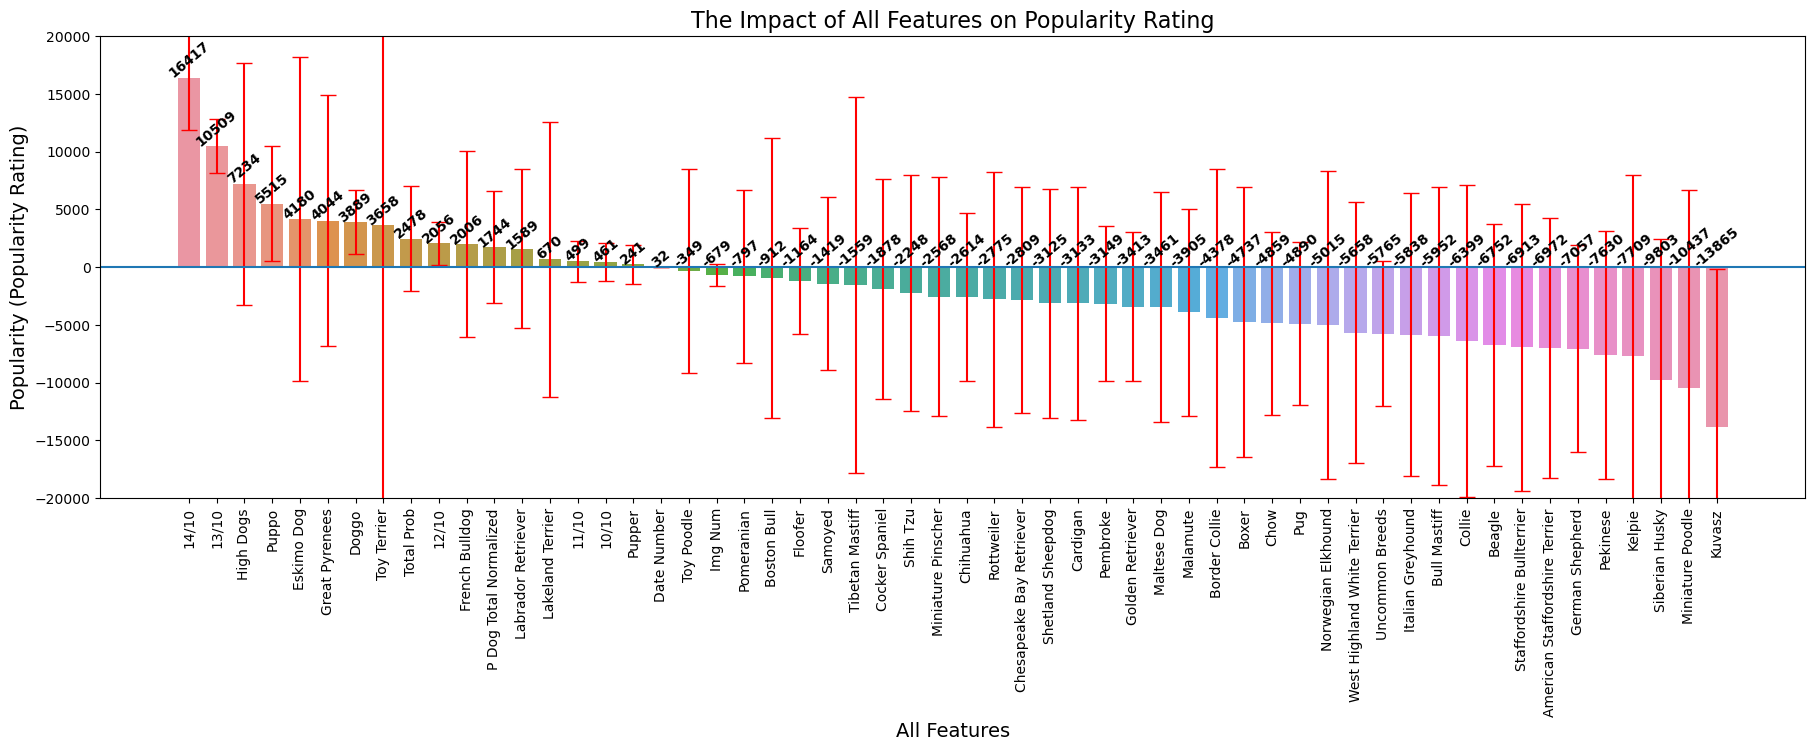

In [124]:
graph6 = er_linear_regression.drop(index=['intercept']).reset_index()

lower_ci = graph6['lower_ci']  
upper_ci = graph6['upper_ci']  
p_value = graph6['p_value']

# Set figure size
plt.figure(figsize=(22, 6)) 

# Create bar plot
ax = sns.barplot(data=graph6, x='index', y='coefficient')
ax.set_ylim(-20000, 20000)

# Add error bars
ax.errorbar(graph6['index'], graph6['coefficient'], color='red',
            yerr=[graph6['coefficient'] - lower_ci, upper_ci - graph6['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph6.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ), f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)

# Set y-ticks and labels
plt.xlabel("All Features", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=90, ticks= range(len(graph6['index'])), labels=graph6['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"The Impact of All Features on Popularity Rating", fontsize=16); 


In [125]:
def significant_variables(df=final_df, dependent_variable='PR', independent_variables=all_characteristics, threshhold=0.05):
    lm = sm.OLS(df[dependent_variable], df[list(independent_variables)])  # Convert set to list here
    results = lm.fit()

    er_linear_regression = pd.DataFrame(
        {
            "coefficient": results.params.astype('int'),
            "lower_ci": results.conf_int()[0].astype('int'),
            "upper_ci": results.conf_int()[1].astype('int'),
            "std_err": results.bse.astype('int'),
            "p_value": results.pvalues 
        }
    )

    er_linear_regression = round(er_linear_regression.sort_values(by=f'coefficient', ascending=False), 6).copy()
    elimination = set(er_linear_regression.query(f'p_value > {threshhold}').index) - {'intercept'}

    if len(elimination) > 0:
        remaining_variables = set(independent_variables) - elimination
        return significant_variables(df, dependent_variable, remaining_variables, threshhold)
    else:
        print(results.summary())
        print(er_linear_regression)
        return results, er_linear_regression

er_linear_regression = significant_variables(threshhold=0.18)[1]


                            OLS Regression Results                            
Dep. Variable:                     PR   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     164.6
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.67e-191
Time:                        12:37:56   Log-Likelihood:                -20986.
No. Observations:                1946   AIC:                         4.199e+04
Df Residuals:                    1938   BIC:                         4.203e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
13/10            1.006e+04    987.614     

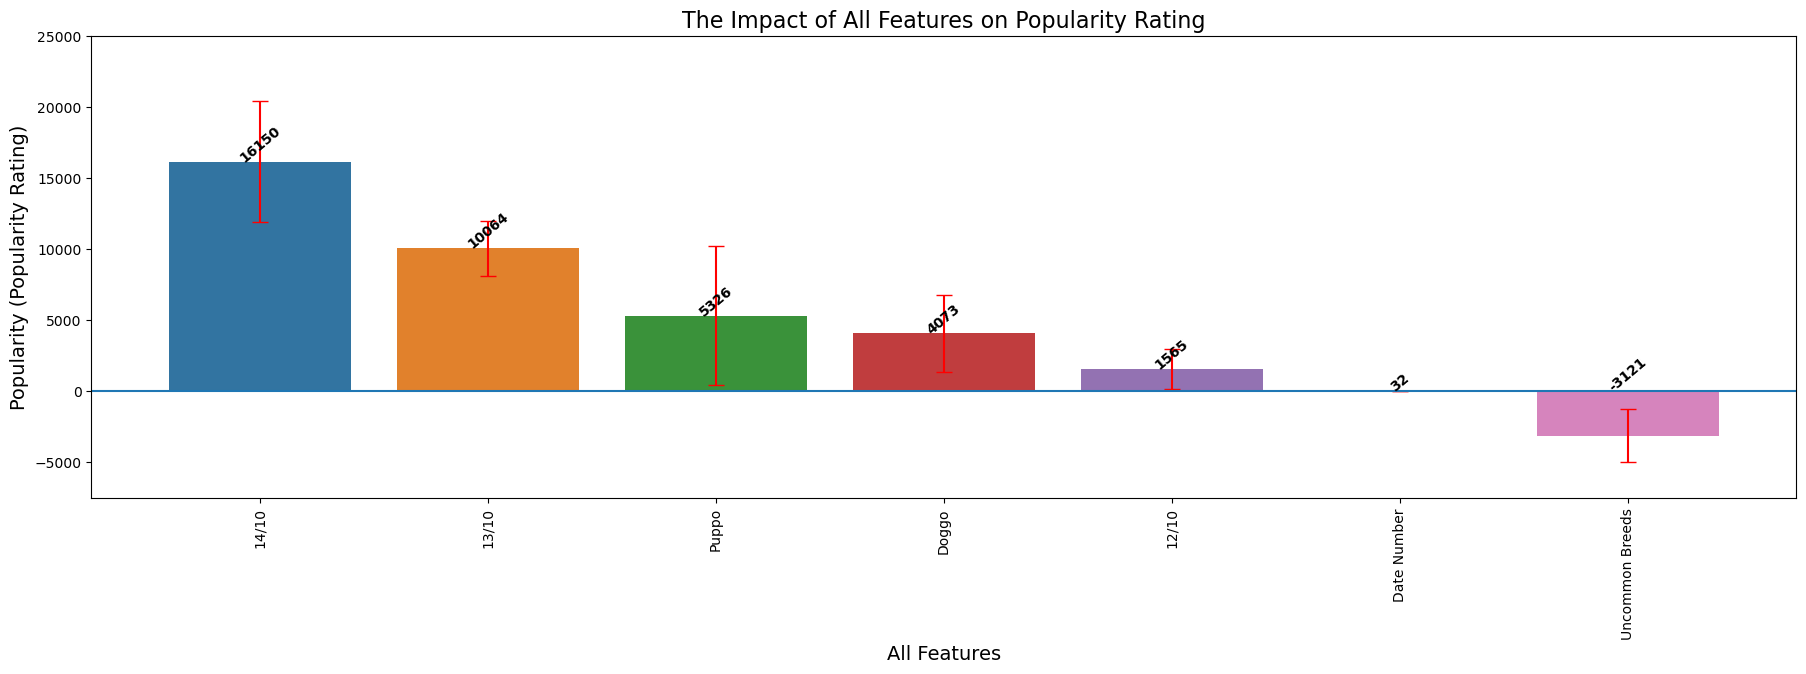

In [126]:
graph7 = er_linear_regression.drop(index=['intercept']).reset_index()

lower_ci = graph7['lower_ci']  
upper_ci = graph7['upper_ci']  
p_value = graph7['p_value']

# Set figure size
plt.figure(figsize=(22, 6)) 

# Create bar plot
ax = sns.barplot(data=graph7, x='index', y='coefficient')
ax.set_ylim(-7500, 25000)

# Add error bars
ax.errorbar(graph7['index'], graph7['coefficient'], color='red',
            yerr=[graph7['coefficient'] - lower_ci, upper_ci - graph7['coefficient']], 
            fmt='none', capsize=6)

for i, row in graph7.iterrows():
    ax.text(i, row['coefficient']**(row['coefficient'] / abs(row['coefficient']) ), f"{round(row['coefficient'], 6)}", ha='center', weight='bold', rotation=40)

# Set y-ticks and labels
plt.xlabel("All Features", fontsize=14)
plt.ylabel(f"Popularity (Popularity Rating)", fontsize=14)
plt.xticks(rotation=90, ticks= range(len(graph7['index'])), labels=graph7['index'].str.replace('_', ' ').str.title())
plt.axhline(0)
plt.title(f"The Impact of All Features on Popularity Rating", fontsize=16); 


## <a id='toc1_11_'></a>[Model Questions](#toc0_)

### <a id='toc1_11_1_'></a>[Relationship Questions](#toc0_)

In [127]:
master_df.describe()

,doggo,floofer,pupper,puppo,retweet_count,favorite_count,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,total_prob,p_dog_total,p1_conf_normalized,p2_conf_normalized,p3_conf_normalized,p_dog_total_normalized,hour,date_number,PR,10/10,11/10,12/10,13/10,14/10,high_dogs,intercept
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1.946000e+03,1946.000000,1.946000e+03,1946.000000,1946.000000,1946.000000,1946.000000,1.946000e+03,1.946000e+03,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.0
mean,0.039568,0.013875,0.115108,0.011819,2192.755396,7482.909558,1.202467,0.593567,0.740493,1.349651e-01,0.749229,6.021116e-02,0.724049,0.788743,0.604314,0.716100,1.894028e-01,9.449717e-02,0.739999,9.746660,192.549846,9675.664954,0.213258,0.201439,0.228160,0.127955,0.016958,0.002569,1.0
std,0.194993,0.117001,0.319234,0.108099,3925.754576,11027.250949,0.560127,0.272345,0.438477,1.010762e-01,0.433568,5.083807e-02,0.447107,0.210276,0.377976,0.199034,1.315855e-01,8.715370e-02,0.404227,8.631565,186.552564,14745.961723,0.409714,0.401178,0.419754,0.334125,0.129147,0.050637,0.0
min,0.000000,0.000000,0.000000,0.000000,11.000000,62.000000,1.000000,0.044333,0.000000,1.011300e-08,0.000000,1.740170e-10,0.000000,0.126448,0.000000,0.337645,1.011300e-08,1.740170e-10,0.000000,0.000000,0.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,484.000000,1575.500000,1.000000,0.360998,0.000000,5.387868e-02,0.000000,1.606823e-02,0.000000,0.654885,0.216314,0.534280,6.178821e-02,1.702943e-02,0.468705,1.000000,26.000000,2066.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,1053.500000,3375.000000,1.000000,0.587222,1.000000,1.178485e-01,1.000000,4.950530e-02,1.000000,0.855834,0.751551,0.718661,1.908002e-01,7.028311e-02,1.000000,4.000000,117.000000,4399.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,2514.750000,9337.500000,1.000000,0.846285,1.000000,1.962177e-01,1.000000,9.159438e-02,1.000000,0.971472,0.946786,0.908691,3.031390e-01,1.560522e-01,1.000000,18.000000,336.750000,11892.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,68769.000000,140268.000000,4.000000,1.000000,1.000000,4.880140e-01,1.000000,2.710420e-01,1.000000,1.000000,0.999998,1.000000,4.895624e-01,3.257113e-01,1.000000,23.000000,624.000000,209037.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


### <a id='toc1_11_2_'></a>[Visualization](#toc0_)

In [128]:
master_df['hour'] = master_df.timestamp.dt.hour

In [129]:
master_df.groupby('hour').tweet_id.count()


hour
0     248
1     270
2     205
3     164
4      94
5      25
6       3
13      1
14      8
15     90
16    185
17    156
18     98
19     81
20     75
21     68
22     67
23    108
Name: tweet_id, dtype: int64

Text(0.5, 0, 'Hour of Day')

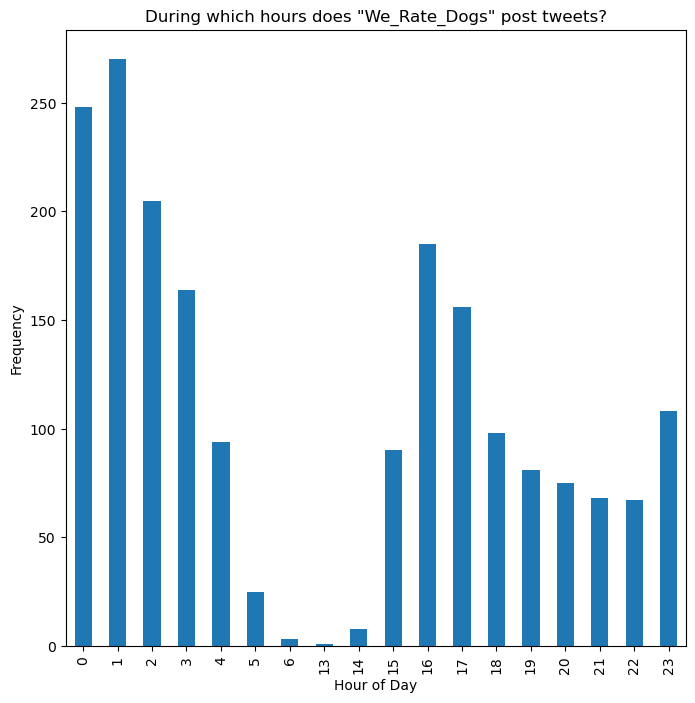

In [130]:
master_df.groupby('hour').tweet_id.count().plot(kind='bar', figsize=(8,8))
plt.title('During which hours does "We_Rate_Dogs" post tweets?')
plt.ylabel('Frequency')
plt.xlabel('Hour of Day')

Text(0.5, 0, 'Device')

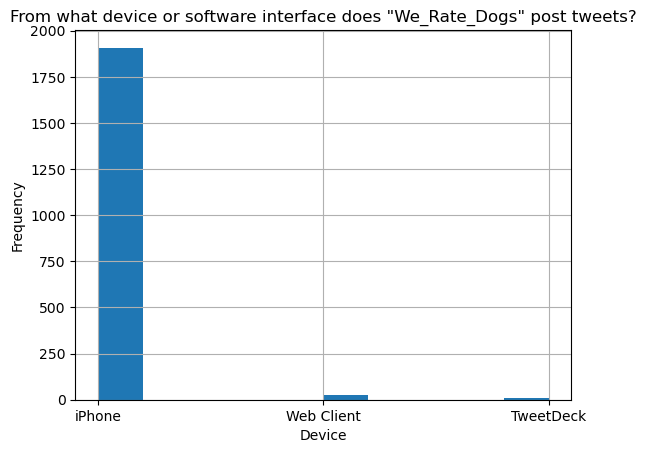

In [131]:
master_df.source.hist()

plt.title('From what device or software interface does "We_Rate_Dogs" post tweets?')
plt.ylabel('Frequency')
plt.xlabel('Device')

Text(0.5, 0, 'Confidence Level')

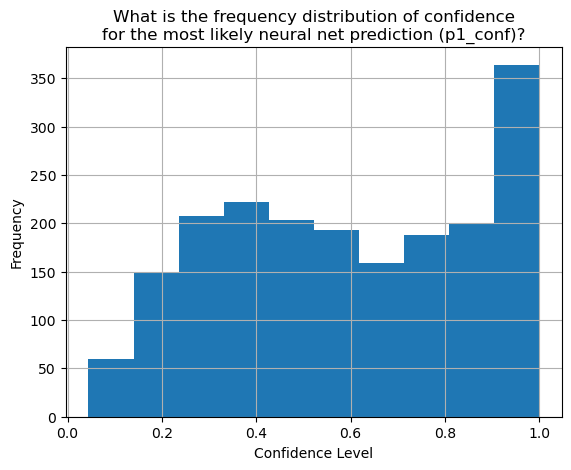

In [132]:
master_df.p1_conf.hist()


plt.title('What is the frequency distribution of confidence\nfor the most likely neural net prediction (p1_conf)?')
plt.ylabel('Frequency')
plt.xlabel('Confidence Level')

Text(0.5, 0, 'Confidence Level')

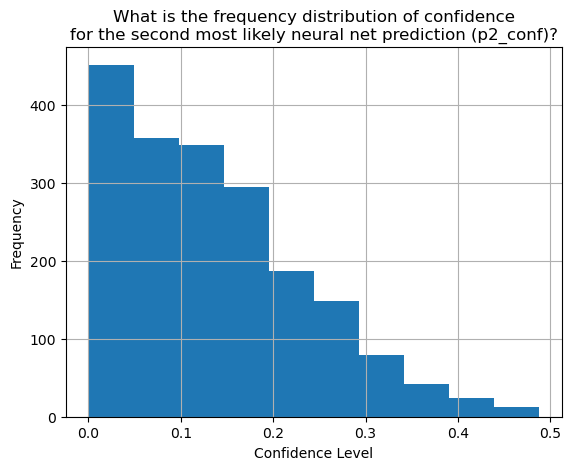

In [133]:
master_df.p2_conf.hist()

plt.title('From what device or software interface does "We_Rate_Dogs" post tweets?')
plt.ylabel('Frequency')
plt.xlabel('Device')

plt.title('What is the frequency distribution of confidence\nfor the second most likely neural net prediction (p2_conf)?')
plt.ylabel('Frequency')
plt.xlabel('Confidence Level')

Text(0.5, 0, 'Confidence Level')

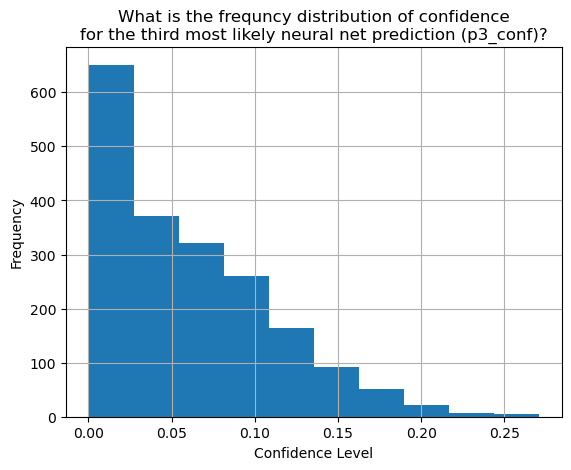

In [134]:
master_df.p3_conf.hist()

plt.title('What is the frequncy distribution of confidence\nfor the third most likely neural net prediction (p3_conf)?')
plt.ylabel('Frequency')
plt.xlabel('Confidence Level')